# Intelligent Data Development - Project 1
## Glovo Time Series Analysis

### by Natalia Beltrán, Clarice Mottet, Tatiana Bakwenye

0. **[Part 0: Set Up and Import](#part0)**
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Library initialization
    - Import data into programming environment
    - Conduct missing data and duplication checks and correct accordingly

1. **[Part 1: EDA - Order Distribution](#part1)**
- **Objective**: Evaluate behavior or initial patterns of order information
- **Tasks:**
  - Initial Statistics
  - Histogram creation

2. **[Part 2: EDA - Trends](#part2)**
- **Objective**: Evaluate if a trend occurs
- **Tasks:**
  - Create a time index based linear regression
  - Calculate rolling mean, median, std for different window and window sizes (landed on two week window and one week window size)
  - Compare the time index linear regression and rolling calcs for trend occurance

3. **[Part 3: EDA - Seasonality](#part3)**
- **Objective**: Evaluate occurance of seasonality by different periods
- **Tasks:**
  - By data level (24-hour, Day, Month):
    - Create line plot of order behavior
    - Assess periodogram of periodic behavior on the data level

4. **[Part 4: EDA - Serial Dependence](#part4)**
- **Objective**: Assess if past order behavior is indicative to future order behavior
- **Tasks:**
  - Deseason-data on the 24 and 168 hour level
  - Evaluate if there is/are cycles present
  - Create autocorrelation and partial correlation plots
  - Create lag plots on different levels and assess correlation

5. **[Part 5: Feature Creation](#part5)**
- **Objective**: Based on EDA create features to be used in predicting orders
- **Tasks:**
  - Lag features
  - Seasonality features: fourier series
  - One hot encoded features: day of week
  - Rolling window features

6. **[Part 6: Model Build and Performance](#part6)**
- **Objective**: Build multiple types of models and assess performance
- **Tasks:**
  - Model build
  - Validation prediction
  - Performance assessment

### Overview

**Part 0: Set Up and Import**
We found 18 hours - 3 days with some consecutative missing hours during the night where we had no order information. We added these hours/days into the data and filled in the order information in with a zero assuming that no orders were filled. This is a fine assumption as the time where the order information was missing were low order hours.


## <a id='part0'>Part 0: Set Up and Import</a>
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Library initialization
    - Import data into programming environment
    - Conduct missing data and duplication checks and correct accordingly

- Library initialization

In [61]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from statsmodels.tsa.deterministic import DeterministicProcess
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import Fourier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

XSMALL_SIZE = 8
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 3

plt.rc('font', size=XSMALL_SIZE)           # controls default text sizes\\n\",\n",
plt.rc('axes', titlesize=XSMALL_SIZE)     # fontsize of the axes title\\n\",\n",
plt.rc('axes', labelsize=XSMALL_SIZE)    # fontsize of the x and y labels\\n\",\n",
plt.rc('xtick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('ytick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('legend', fontsize=XSMALL_SIZE)    # legend fontsize\\n\",\n",
plt.rc('figure', titlesize=XSMALL_SIZE)  # fontsize of the figure title\\n\",\n",
plt.rc('figure', figsize=(7, 2))
plt.rc('figure', dpi=200)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

#paths
# path_in_ = r'/home/clarice/Documents/VSCode/Term3/Intelligent_Data/IDD_glovo_time_series/inputs/'
# path_out_ = r'/home/clarice/Documents/VSCode/Term3/Intelligent_Data/IDD_glovo_time_series/outputs/'


#global variables
TARGET = 'orders'

- Import data into programming environment

In [9]:
#import data into python

# df_orders = pd.read_csv(path_in_ + 'data_BCN.csv', dtype = str)
df_orders = pd.read_csv('data_BCN.csv', dtype = str)
df_orders['time'] = pd.to_datetime(df_orders['time'])
df_orders['orders'] = pd.to_numeric(df_orders['orders'])

df_orders.sort_values(by = ['time'], inplace = True)
df_orders.reset_index(drop = True, inplace = True)

df_view = df_orders.tail(168*4)
# df_view.to_excel(path_out_+'tail of orders.xlsx', index = False)


#Split the data into test, validation and orders
#We perform the split knowing the below duplicate issue and missing data issue
#does not occur in the validation and test time frame

#test is the last week of January
#1/24/2022--1/30/2022 (Mon--Sun)
df_test = df_orders[df_orders['time']>pd.to_datetime('2022-01-23')].copy()
df_test = df_test[df_test['time']<pd.to_datetime('2022-01-31')]

#validation is the second and third week of January
#W1: 1/10/2022--1/16/2022 (Mon--Sun)
#W2: 1/17/2022--1/23/2022 (Mon--Sun)
df_val = df_orders[df_orders['time']>pd.to_datetime('2022-01-09')].copy()
df_val = df_val[df_val['time']<pd.to_datetime('2022-01-24')]
#created week_ind that specifies the dataset two weeks
df_val['week_ind'] = 1
df_val.loc[(df_val['time']>pd.to_datetime('2022-01-16')), 'week_ind'] = 2

#the data for training is all other dates
df_orders = df_orders[df_orders['time']<pd.to_datetime('2022-01-10')]

# df_val = df_orders[df_orders['time']>=pd.to_datetime('2022-01-01')].copy()
# df_orders = df_orders[df_orders['time']<pd.to_datetime('2022-01-01')]

In [10]:
df_orders.head()

time  orders city
0 2021-02-01 00:00:00     0.0  BCN
1 2021-02-01 01:00:00     0.0  BCN
2 2021-02-01 02:00:00     0.0  BCN
3 2021-02-01 03:00:00     0.0  BCN
4 2021-02-01 04:00:00     0.0  BCN

- Conduct missing data and duplication checks and correct accordingly

In [11]:
#basic stats - time

df_orders[['time']].describe().T

C:\Users\bakwe\AppData\Local\Temp\ipykernel_23040\2788512640.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_orders[['time']].describe().T


count unique        top freq      first                last
time  8214   8214 2021-02-01    1 2021-02-01 2022-01-09 23:00:00

Start Time: 2021-02-01
  End Time: 2022-02-01

Data appears to be on hourly level.

In [12]:
#data checks - null, duplicates, missing?

#are there any orders with null information?
print("number of null orders:",df_orders['orders'].isna().sum())

#do we have duplicate order information?
df_view = df_orders.copy()
df_view.drop_duplicates(subset = ['time'], inplace = True)
print("import row count:", len(df_orders['time']))
print("post dup rmv row count:", len(df_view['time']))
del df_view

#are we missing any minute by minute order information?
start_time = pd.to_datetime('2021-02-01')
end_time = pd.to_datetime('2022-01-01')
date_range = pd.date_range(start=start_time, end=end_time, freq='h')
df_all = pd.DataFrame(date_range, columns=['time_all'])
df_all = df_all[df_all['time_all']<end_time]

df_all = df_all.merge(df_orders[['time']], how = 'left', left_on = ['time_all'], right_on = ['time'])
print("number of hours missing:",df_all['time'].isna().sum())
df_all_msng = df_all[df_all['time'].isna()].copy()
print("hours missing order information:")
print(df_all_msng)


number of null orders: 0
import row count: 8214
post dup rmv row count: 8214
number of hours missing: 18
hours missing order information:
                time_all time
336  2021-02-15 00:00:00  NaT
337  2021-02-15 01:00:00  NaT
338  2021-02-15 02:00:00  NaT
339  2021-02-15 03:00:00  NaT
340  2021-02-15 04:00:00  NaT
341  2021-02-15 05:00:00  NaT
3024 2021-06-07 00:00:00  NaT
3025 2021-06-07 01:00:00  NaT
3026 2021-06-07 02:00:00  NaT
3027 2021-06-07 03:00:00  NaT
3028 2021-06-07 04:00:00  NaT
3029 2021-06-07 05:00:00  NaT
6216 2021-10-18 00:00:00  NaT
6217 2021-10-18 01:00:00  NaT
6218 2021-10-18 02:00:00  NaT
6219 2021-10-18 03:00:00  NaT
6220 2021-10-18 04:00:00  NaT
6221 2021-10-18 05:00:00  NaT


In [13]:
#add in the hours that the orders data frame is currently missing

#add in the missing hours
df_orders = df_all[['time_all']].merge(df_orders, how = 'left', left_on = ['time_all'], right_on = ['time'])
df_orders.sort_values(by = ['time_all'], inplace = True)

#set missing hour order count to zero
df_orders.loc[df_orders['orders'].isna(), 'orders'] = 0

print("number of nulls",df_orders['orders'].isna().sum())

df_orders_msng = df_orders[df_orders['time'].isna()].copy()
print(df_orders_msng)

df_orders.loc[df_orders['time'].isna(), 'time'] = df_orders['time_all']
df_orders.sort_values(by = ['time_all'], inplace = True)
df_orders.reset_index(drop = True, inplace = True)
df_orders = df_orders[['time', 'orders', 'city']]

number of nulls 0
                time_all time  orders city
336  2021-02-15 00:00:00  NaT     0.0  NaN
337  2021-02-15 01:00:00  NaT     0.0  NaN
338  2021-02-15 02:00:00  NaT     0.0  NaN
339  2021-02-15 03:00:00  NaT     0.0  NaN
340  2021-02-15 04:00:00  NaT     0.0  NaN
341  2021-02-15 05:00:00  NaT     0.0  NaN
3024 2021-06-07 00:00:00  NaT     0.0  NaN
3025 2021-06-07 01:00:00  NaT     0.0  NaN
3026 2021-06-07 02:00:00  NaT     0.0  NaN
3027 2021-06-07 03:00:00  NaT     0.0  NaN
3028 2021-06-07 04:00:00  NaT     0.0  NaN
3029 2021-06-07 05:00:00  NaT     0.0  NaN
6216 2021-10-18 00:00:00  NaT     0.0  NaN
6217 2021-10-18 01:00:00  NaT     0.0  NaN
6218 2021-10-18 02:00:00  NaT     0.0  NaN
6219 2021-10-18 03:00:00  NaT     0.0  NaN
6220 2021-10-18 04:00:00  NaT     0.0  NaN
6221 2021-10-18 05:00:00  NaT     0.0  NaN


In [14]:
#extract out features from time field (hour, day, month, year)

df_orders['year'] = df_orders['time'].dt.year
df_orders['month'] = df_orders['time'].dt.month
df_orders['day'] = df_orders['time'].dt.day
df_orders['hour'] = df_orders['time'].dt.hour
df_orders['date'] = pd.to_datetime(df_orders[['year','month','day']])
df_orders['dayofweek'] = df_orders['time'].dt.day_of_week
df_orders['dayofyear'] = df_orders['time'].dt.day_of_year

df_orders.sort_values(by = ['time'], inplace = True)
df_orders.reset_index(drop = True, inplace = True)

df_orders['time_index'] = 1
df_orders['time_index'] = df_orders['time_index'].cumsum()


## <a id='part1'>Part 1: EDA - Order Distribution</a>
- **Objective**: Evaluate behavior or initial patterns of order information
- **Tasks:**
  - Initial Statistics
  - Histogram creation

- **Overview**:
  - The median is 30 and the mean is 72.99 so the data is extremely right skewed.
  - When hour blocks with zero orders are removed the median is 61 and the mean is 107.08 so still very right skewed.
  - Once there are more than 70-ish orders occurring, the difference between the median and mean grows.


- Initial Statistics and Histogram: All data

We're seeing a large number of hours where there are no orders made and the difference between the mean and median is quite large, data is extremely skewed.

In [15]:
#general statistics

df_orders[[TARGET]].describe().round(2).T

count   mean     std  min  25%   50%   75%    max
orders  8016.0  71.11  107.89  0.0  0.0  29.0  93.1  939.0

array([[<AxesSubplot: title={'center': 'orders'}>]], dtype=object)

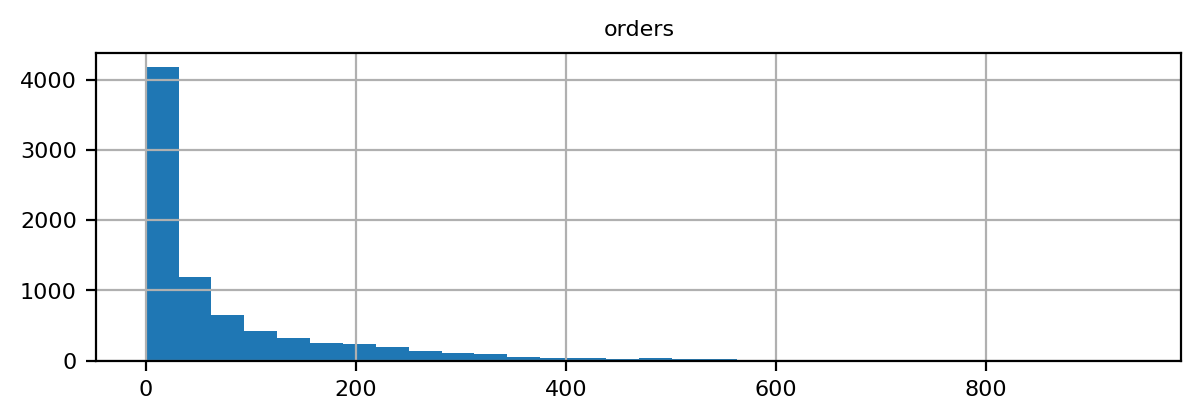

In [16]:
df_orders[[TARGET]].hist(bins=30)

- Initial Statistics and Histogram: Data with zero orders removed

We remove orders that are equal to zero to evaluate if the "skewed-ness" is related to these and find that there is still a significant difference between the mean and median and the data is still very skewed.

In [17]:
df_view = df_orders[df_orders['orders']>0]
df_view[[TARGET]].describe().round(2).T

count    mean     std  min   25%   50%    75%    max
orders  5466.0  104.28  116.67  0.7  28.0  60.0  148.0  939.0

array([[<AxesSubplot: title={'center': 'orders'}>]], dtype=object)

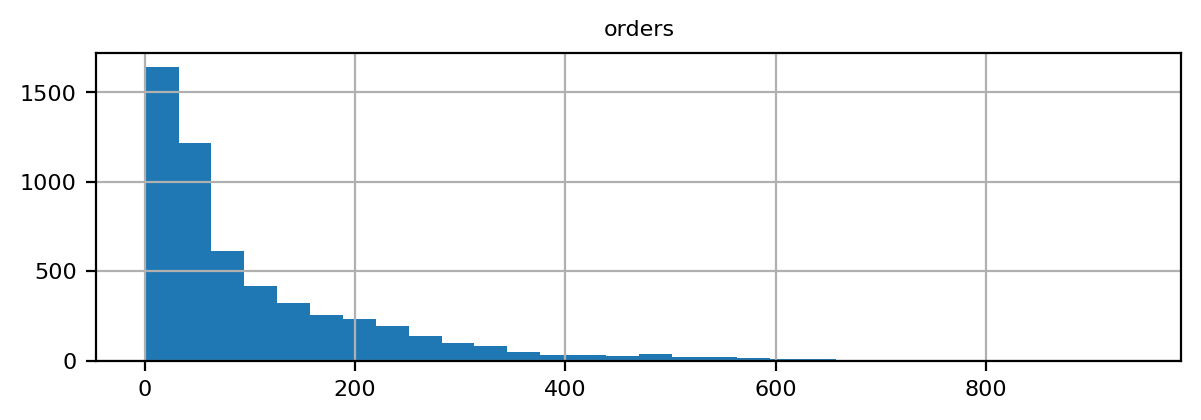

In [18]:
df_view[[TARGET]].hist(bins=30)

- Initial Statistics and Histogram: Subset of data by order amount

We explore if there is an order amount in an hour where the data is not quite skewed and find that when number of orders is at or less than 70, the "skewed-ness" of the data is reduced or at least the difference between the mean and median is minimized. We find that order amount is generally very skewed and order amounts that exceed 400 are generally equally distributed in our time frame-ish.

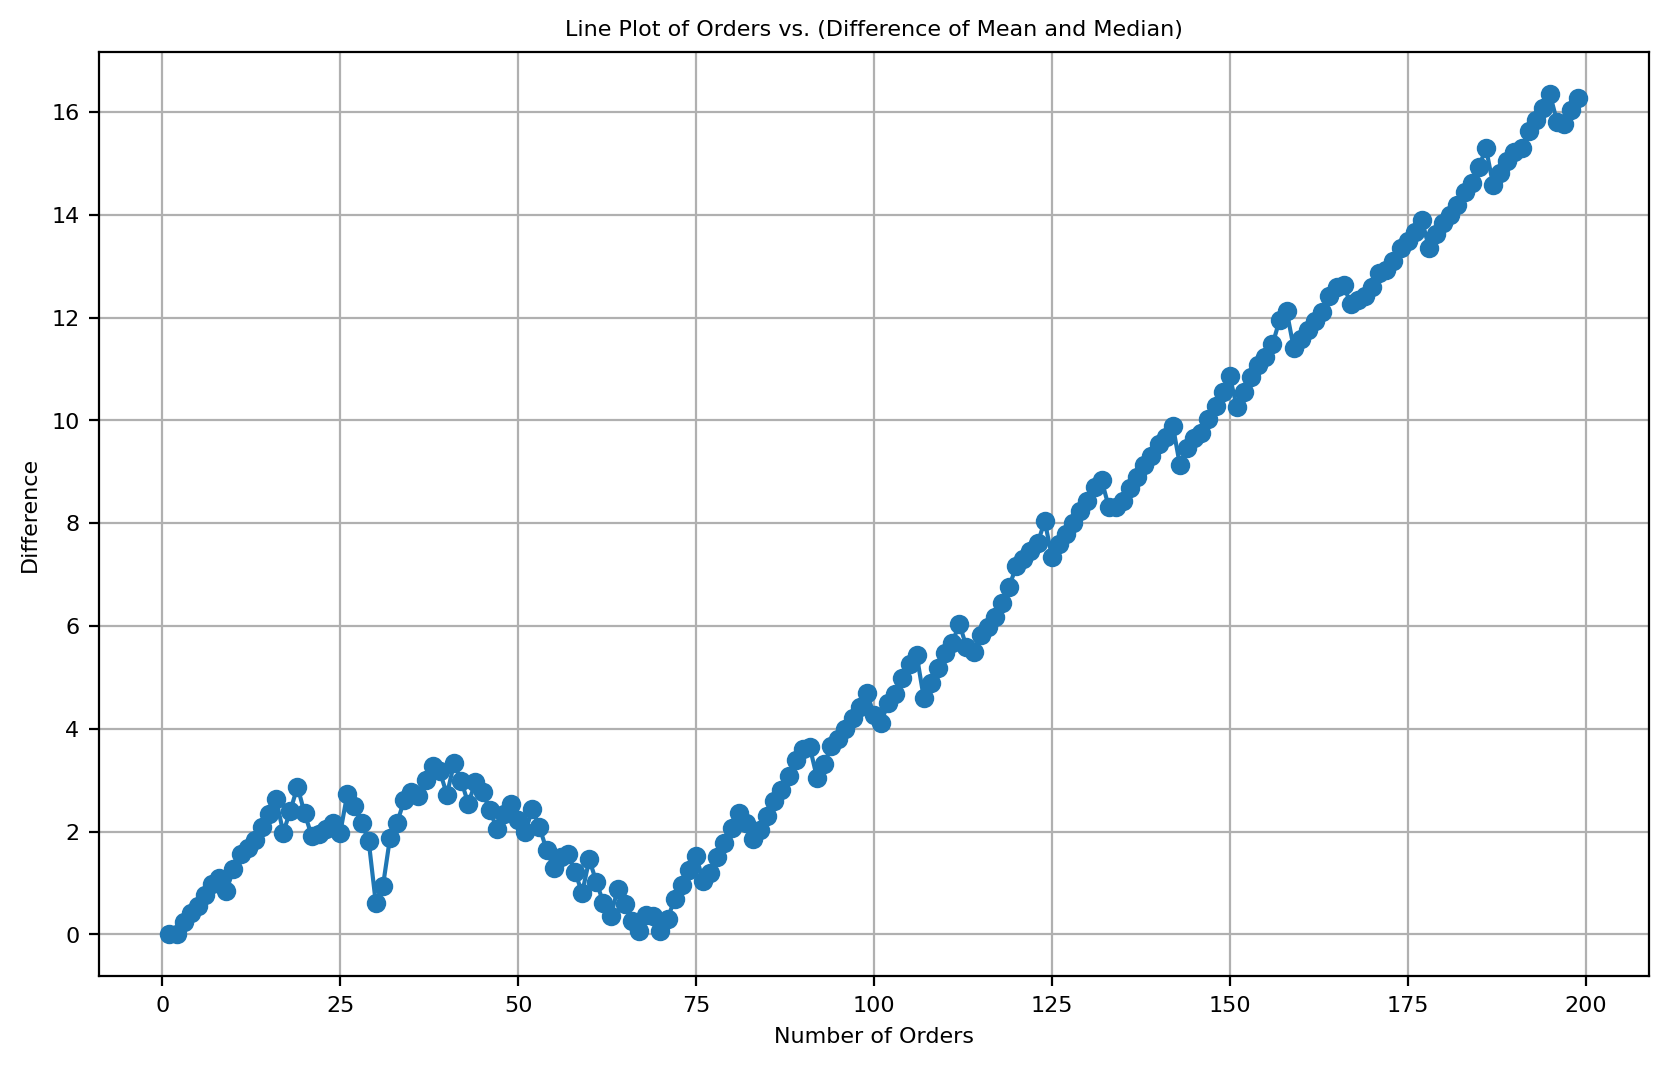

In [19]:
df_view = df_orders[df_orders['orders']>0]

list_ = []

for n_orders in range(1,200):
    df_subset = df_view[df_view['orders']<n_orders]
    mean_ = df_subset['orders'].mean()
    median_ = df_subset['orders'].median()
    diff_ = abs(mean_ - median_)
    dict_ = {'n_orders':n_orders, 'mean':mean_, 'median':median_, 'diff':diff_}
    df_ = pd.DataFrame(dict_, index = [0])
    list_.append(df_)

#plot the n_orders against the difference of the mean and median
df_diff = pd.concat(list_, ignore_index = True)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_diff['n_orders'].values, df_diff['diff'].values, marker='o')  # Line plot with markers
plt.title('Line Plot of Orders vs. (Difference of Mean and Median)')  # Title of the plot
plt.xlabel('Number of Orders')  # X-axis label
plt.ylabel('Difference')  # Y-axis label
plt.grid(True)  # Add grid for better readability
plt.show()


In [20]:
df_view = df_orders[df_orders['orders']>0]
df_view = df_view[df_view['orders']<=70]
print(len(df_orders[TARGET]))
df_view[[TARGET]].describe().round(2).T

8016


count   mean   std  min   25%   50%   75%   max
orders  3028.0  30.27  19.9  0.7  14.0  30.0  45.0  70.0

array([[<AxesSubplot: title={'center': 'orders'}>]], dtype=object)

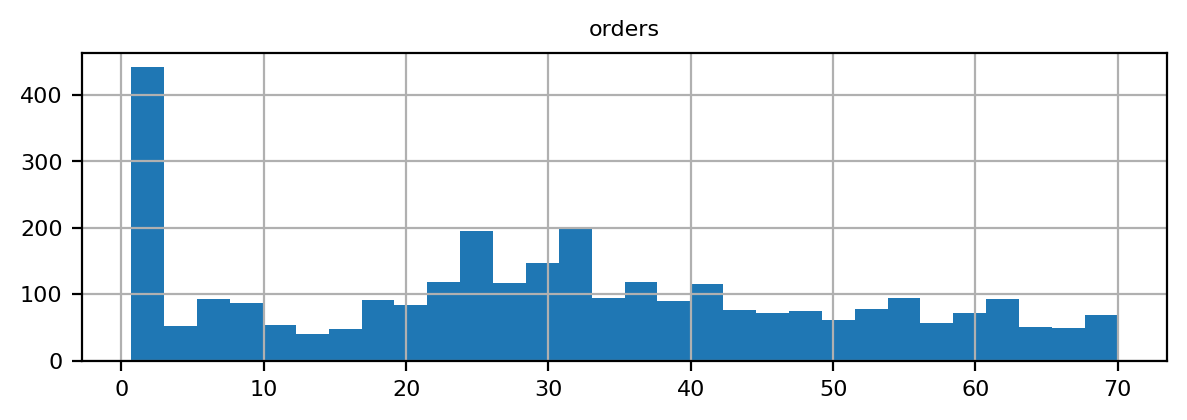

In [21]:
df_view[[TARGET]].hist(bins=30)

In [22]:
#Evaluate distribution of orders that exceed 400 in an hour

df_view = df_orders[df_orders['orders']>0]
df_view = df_view[df_view['orders']>400]
print(len(df_orders[TARGET]))
df_view[[TARGET]].describe().round(2).T

8016


count    mean    std    min    25%    50%     75%    max
orders  180.0  517.15  93.02  401.0  448.5  491.5  563.25  939.0

[Text(0.5, 1.0, 'time vs target'), Text(0, 0.5, 'target')]

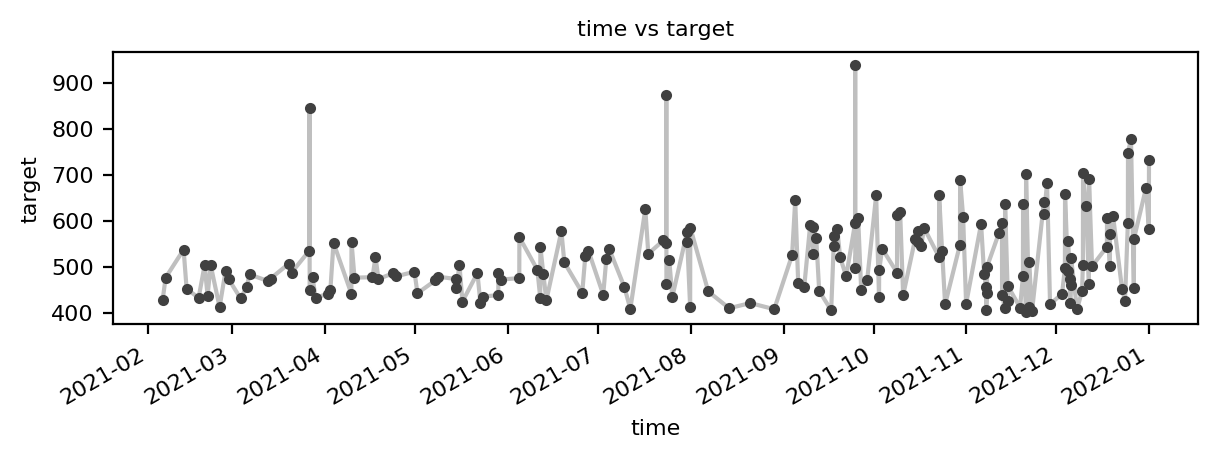

In [23]:
x_val = 'time'
y_val = TARGET

ax = df_view.plot(x = x_val, y = y_val, **plot_params)
ax.set(title = x_val+' vs target', ylabel = 'target')

## <a id='part2'>Part 2: EDA - Trends</a>
- **Objective**: Evaluate if a trend occurs
- **Tasks:**
  - Create a time index based linear regression
  - Calculate rolling mean, median, std for different window and window sizes (landed on two week window and one week window size)
  - Compare the time index linear regression and rolling calcs for trend occurance
- **Overview**:
  - Taken with a grain of salt that the data is very skewed so evaluate trend based on the mean can lead to a skewed trend interpretation, the rate of change for the time index LR was .0035 (not a very compelling indication of a trend). When compared against the rolling median, we similarly saw little evidence that would indicate a trend.

  - Create a time index based linear regression


In [24]:
#LR - time index

X = df_orders[['time_index','time']]
X.set_index('time',inplace = True)
y = df_orders[[TARGET]]  # the target

model = LinearRegression()
model.fit(X, y)

#possible there is a slight trend (1.3% increase)
print(model.coef_)
print(model.intercept_)

y_pred = pd.Series(model.predict(X).flatten(), index=X.index)

[[0.00362549]]
[56.57584211]


  - Calculate rolling mean, median, std for different window and window sizes


In [25]:
#rolling window

df_orders_time = df_orders.set_index('time')
rolling_window = df_orders_time[[TARGET]].rolling(
    window=336,       # two weeks
    center=False,       
    min_periods=168,   # 168 = 24*7 (one week)
)

moving_median = rolling_window.median()  # Compute the median
moving_mean = rolling_window.mean()      # Compute the mean
moving_std = rolling_window.std()      # Compute the mean

  - Compare the time index linear regression and rolling calcs for trend occurance

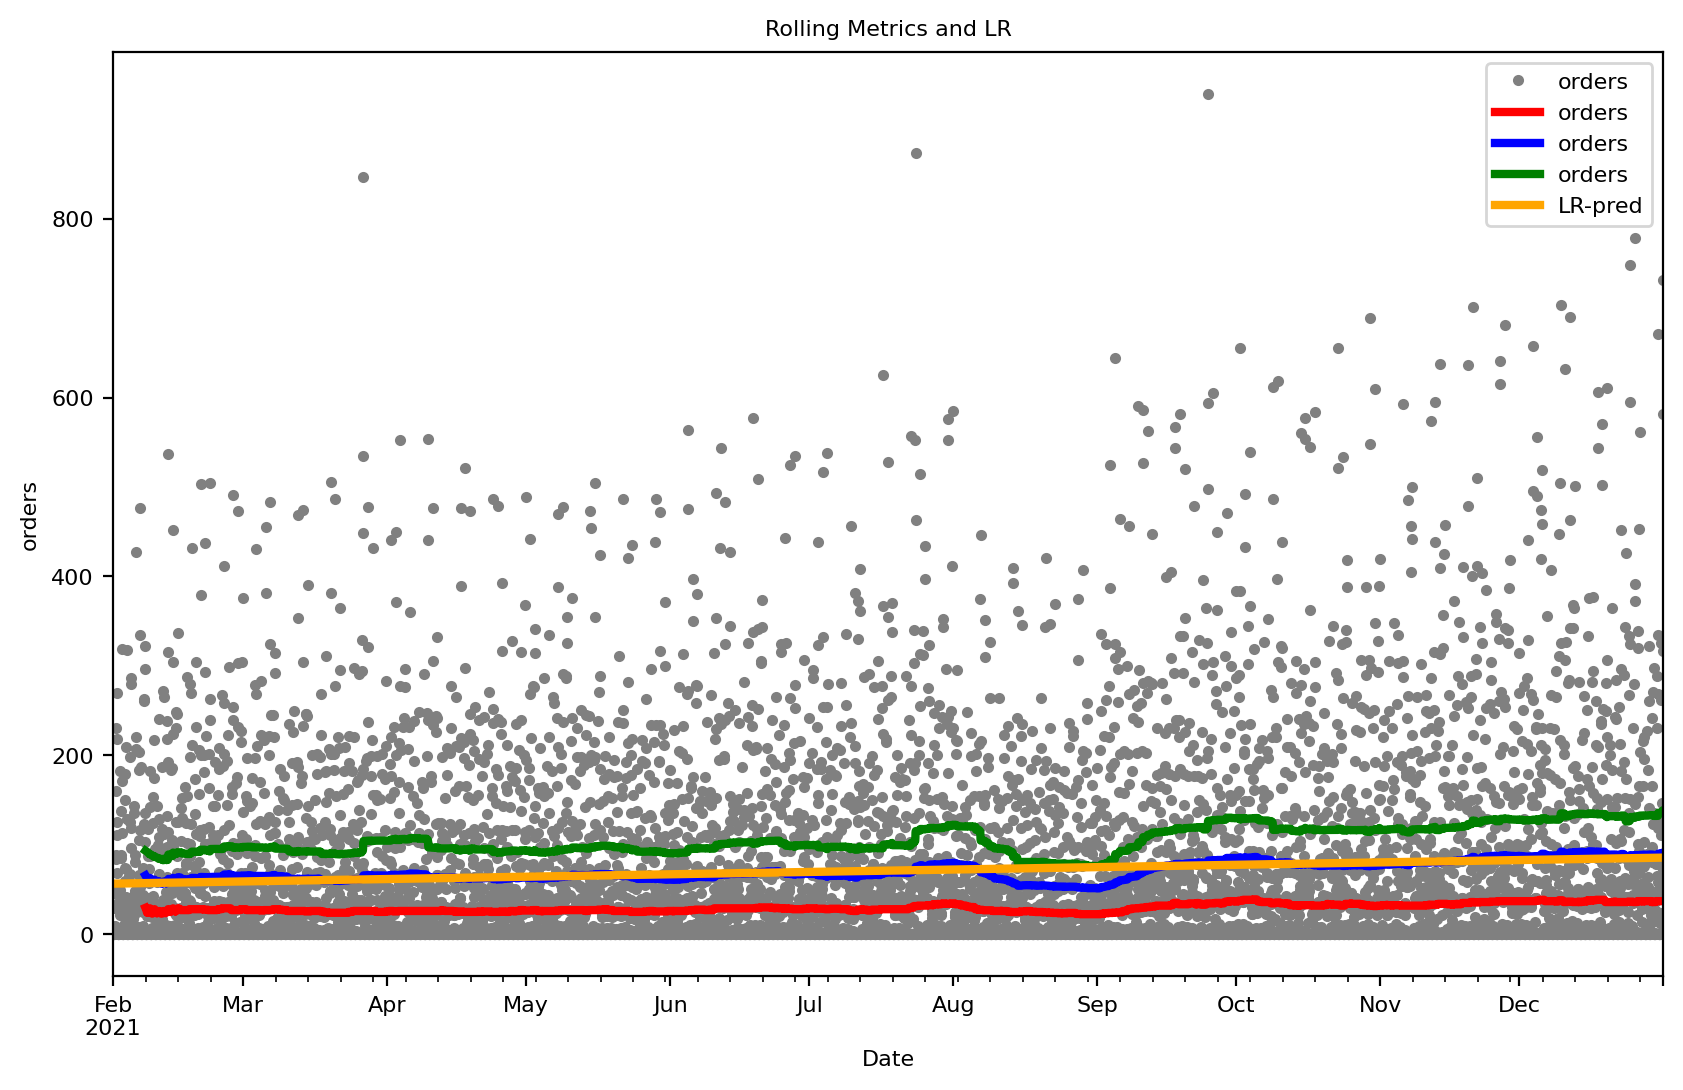

In [26]:
# Plotting
ax = df_orders_time[[TARGET]].plot(style=".", color="0.5", figsize=(10, 6))
moving_median.plot(ax=ax, linewidth=3, color='red', legend=True, label='Rolling Median')
moving_mean.plot(ax=ax, linewidth=3, color='blue', legend=True, label='Rolling Mean')
moving_std.plot(ax=ax, linewidth=3, color='green', legend=True, label='Rolling STD')
y_pred.plot(ax=ax, linewidth=3, color='orange', legend=True, label='LR-pred')
ax.set_title("Rolling Metrics and LR")
ax.set_xlabel("Date")  # Assuming the index of df_orders_time is some datetime type
ax.set_ylabel(TARGET)

plt.show()

## <a id='part3'>Part 3: EDA - Seasonality</a>
- **Objective**: Evaluate occurance of seasonality by different periods
- **Tasks:**
  - By data level (Hour, Day, Month):
    - Create line plot of order behavior
    - Assess periodogram of periodic behavior on the data level
- **Overview:**
  - We saw strong recurrent seasonality behavior by hour of day on the day level.
  - There was strong recurrent seasonality behavior by day of week on the week level.
  - There was not recurrent seasonality behavior on the day of the month of the month of year level.

- Hour of Day:

From the line plot and the periodogram, we see strong indication of recurrent seasonal behavior on the 24-hour period and day of week within a week level.

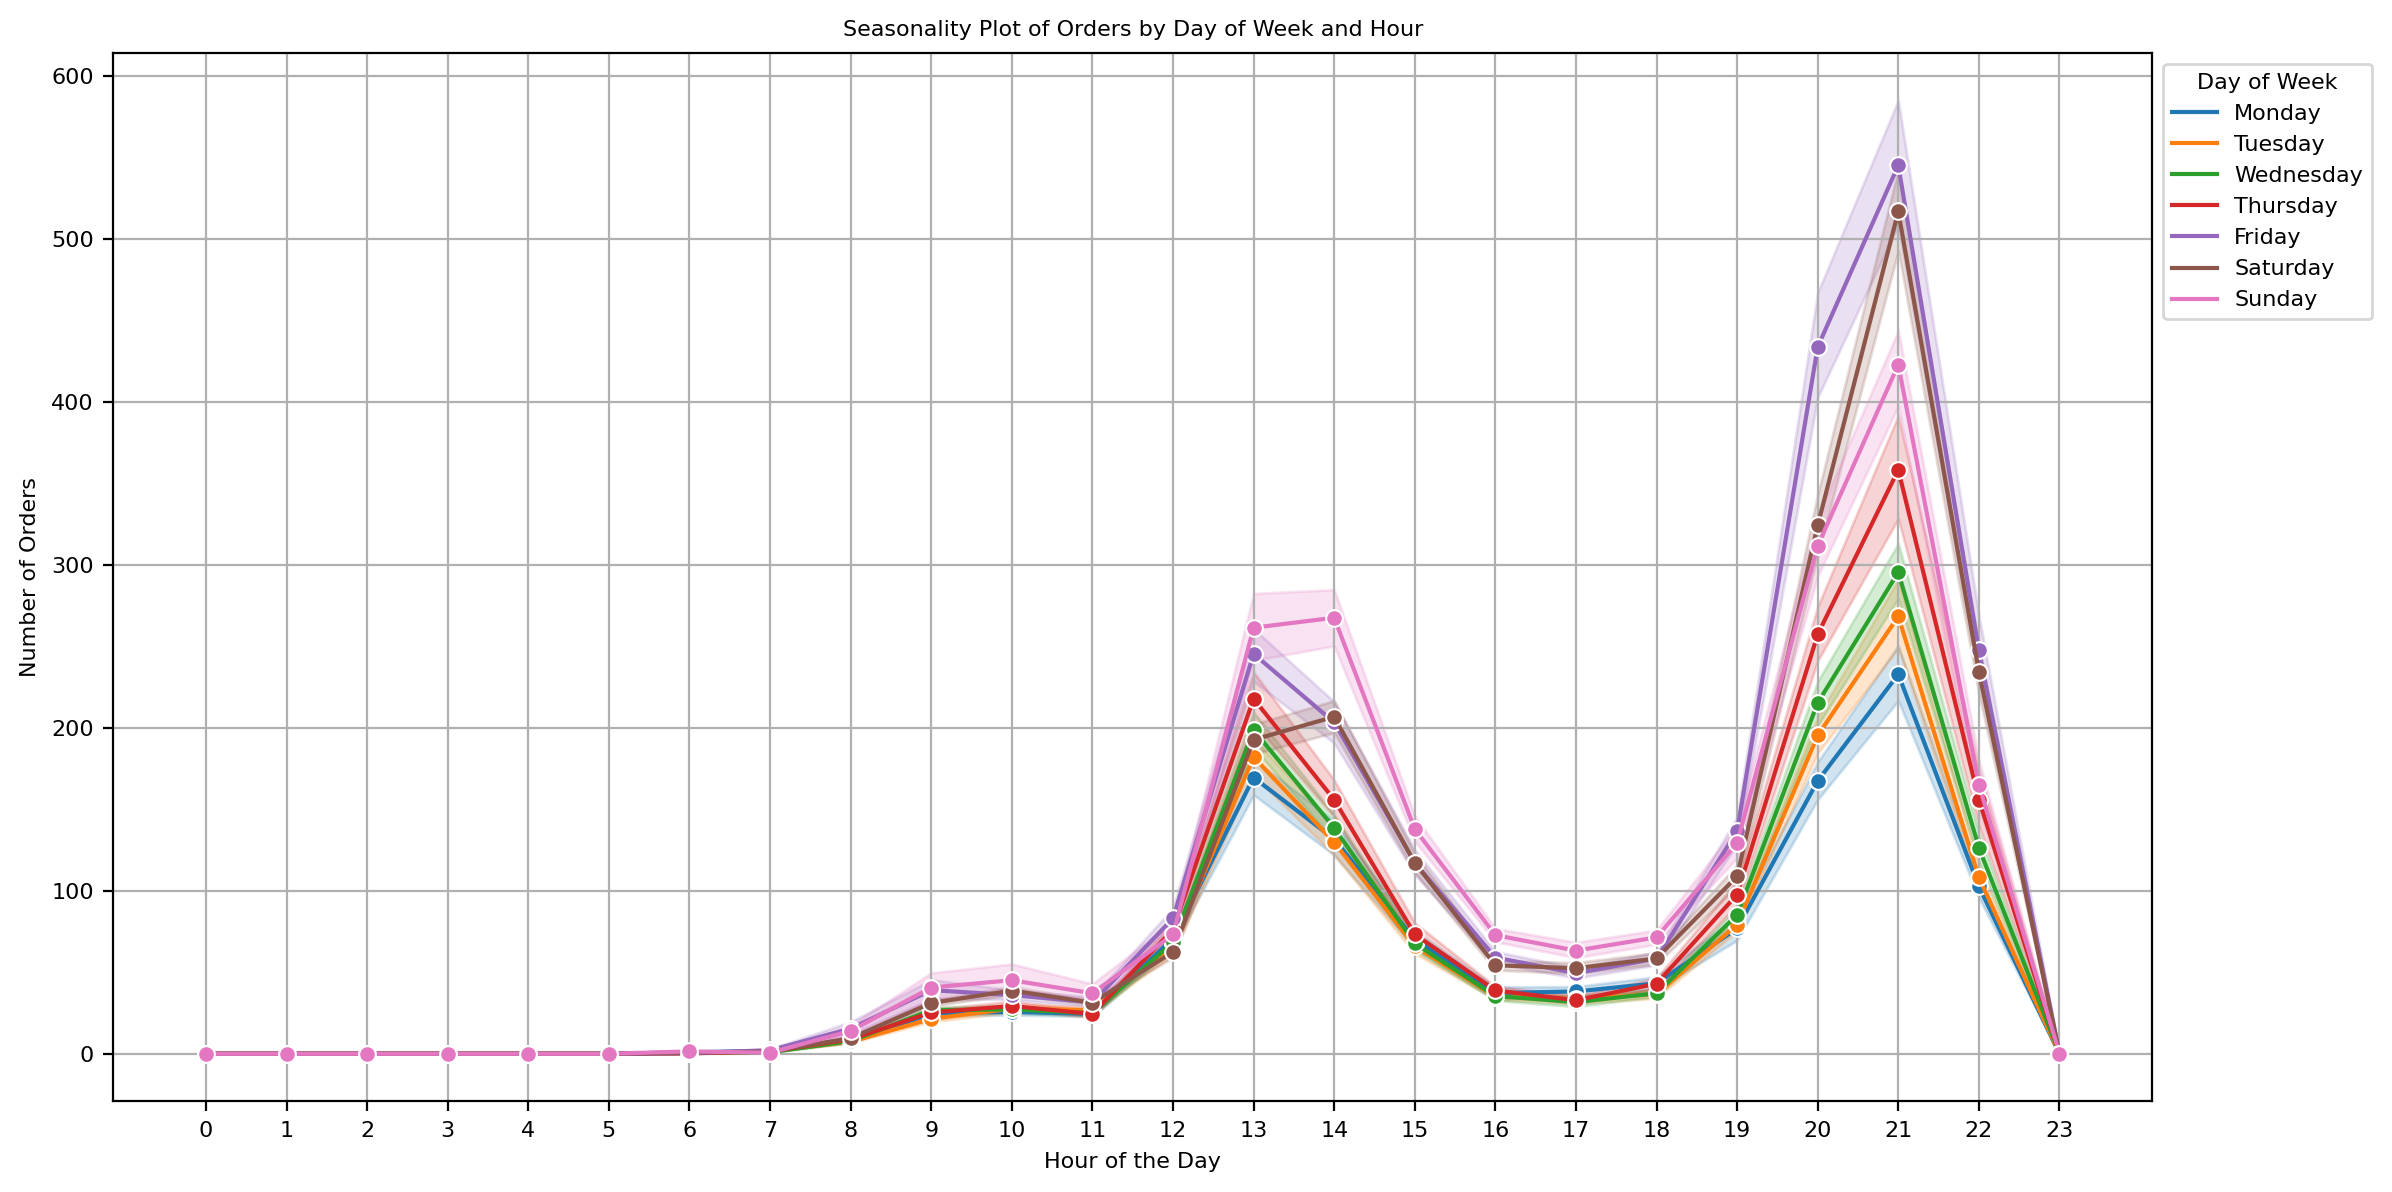

In [27]:
#line plot - hour level by day of week

# Extract day of week and hour from the 'time' column
df_orders['dayofweek'] = df_orders['time'].dt.day_name()
df_orders['hour'] = df_orders['time'].dt.hour

# Create a seasonal plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_orders, x='hour', y='orders', hue='dayofweek', marker='o')

plt.title('Seasonality Plot of Orders by Day of Week and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.xticks(range(24))  # Set x-axis ticks to show every hour
plt.legend(title='Day of Week', loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.tight_layout()
plt.show()


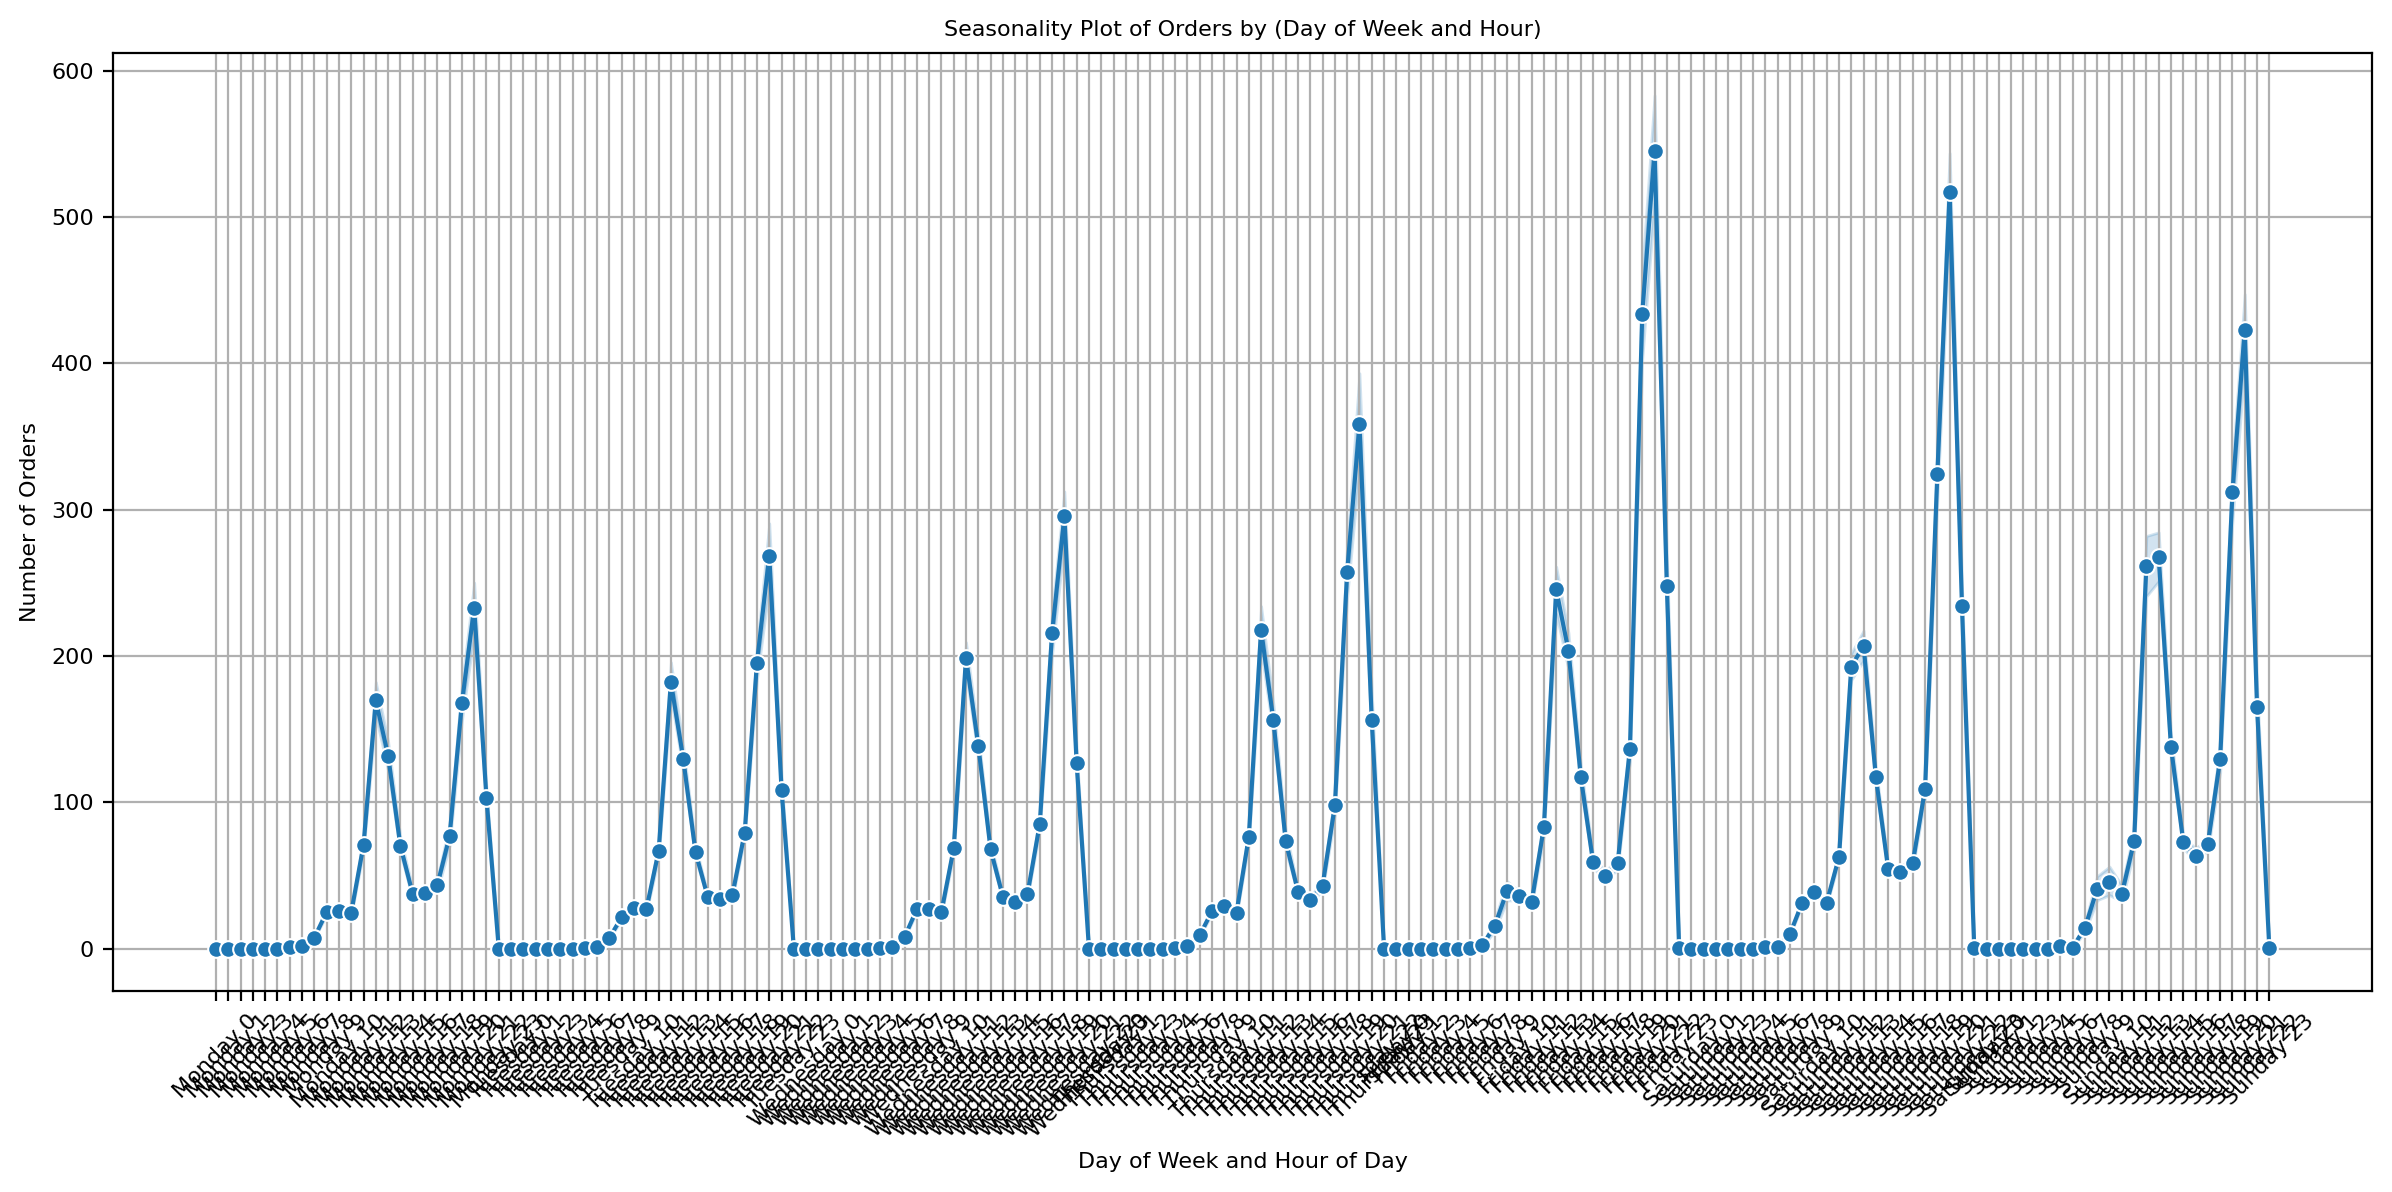

In [28]:
#single line plot - hour of day and day of week

# Extract day of week and hour from the 'time' column
df_orders['dayofweek'] = df_orders['time'].dt.day_name()
df_orders['hour'] = df_orders['time'].dt.hour

# Create a new column combining day of week and hour
df_orders['day_hour'] = df_orders['dayofweek'] + ' ' + df_orders['hour'].astype(str)

# Create a seasonal plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_orders, x='day_hour', y='orders', marker='o')

plt.title('Seasonality Plot of Orders by (Day of Week and Hour)')
plt.xlabel('Day of Week and Hour of Day')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


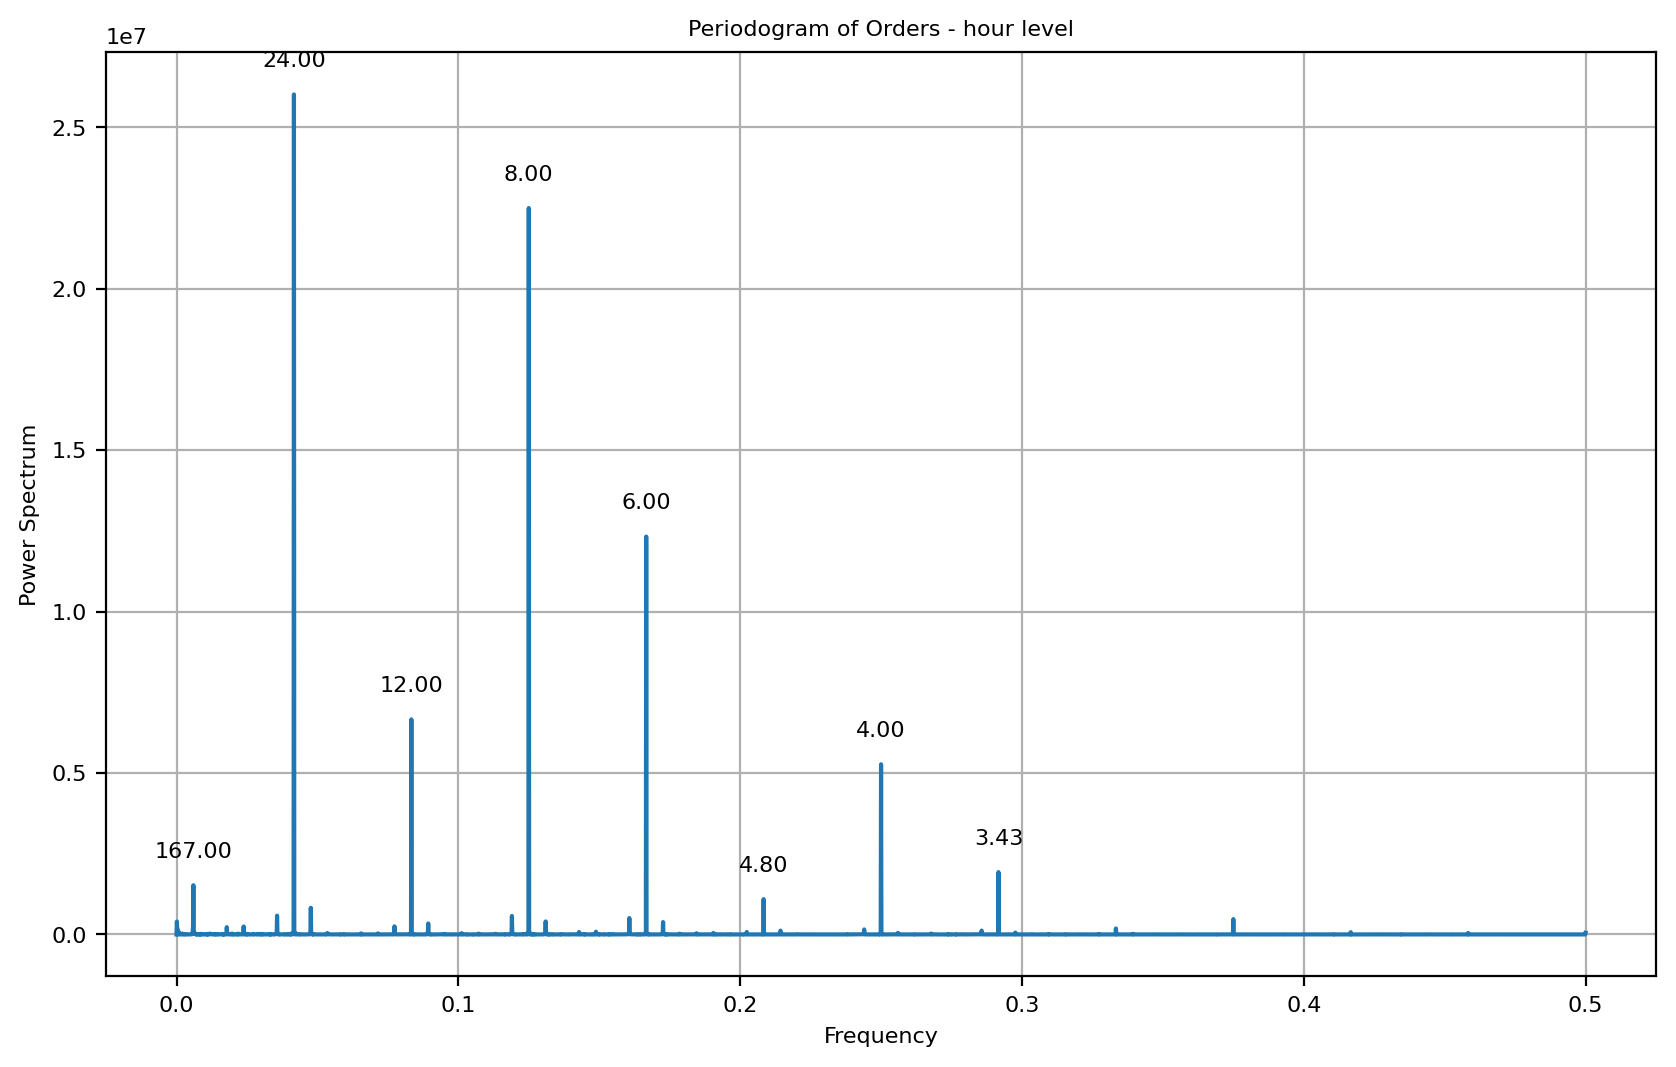

In [29]:
#periodogram: 24 hour level

df_period = df_orders[['time','orders']].copy()

# Set 'time' column as index
df_period.set_index('time', inplace=True)

# Resample data to get hourly counts
hourly_orders = df_period.resample('H').sum()

# Compute periodogram
frequencies, power_spectrum = periodogram(hourly_orders['orders'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_spectrum)
plt.title('Periodogram of Orders - hour level')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.grid(True)

# Annotate points where power spectrum > 0.2
for freq, power in zip(frequencies, power_spectrum):
    if power > 0.1*(1e7):
        freq_ = 1/freq
        plt.annotate(f'{freq_:.2f}', (freq, power), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


- Day of Month

There does not appear to be consistent seasonal behavior on the day within the month level. From the periodogram, we see further indication that there is strong seasonal behavior week to week.

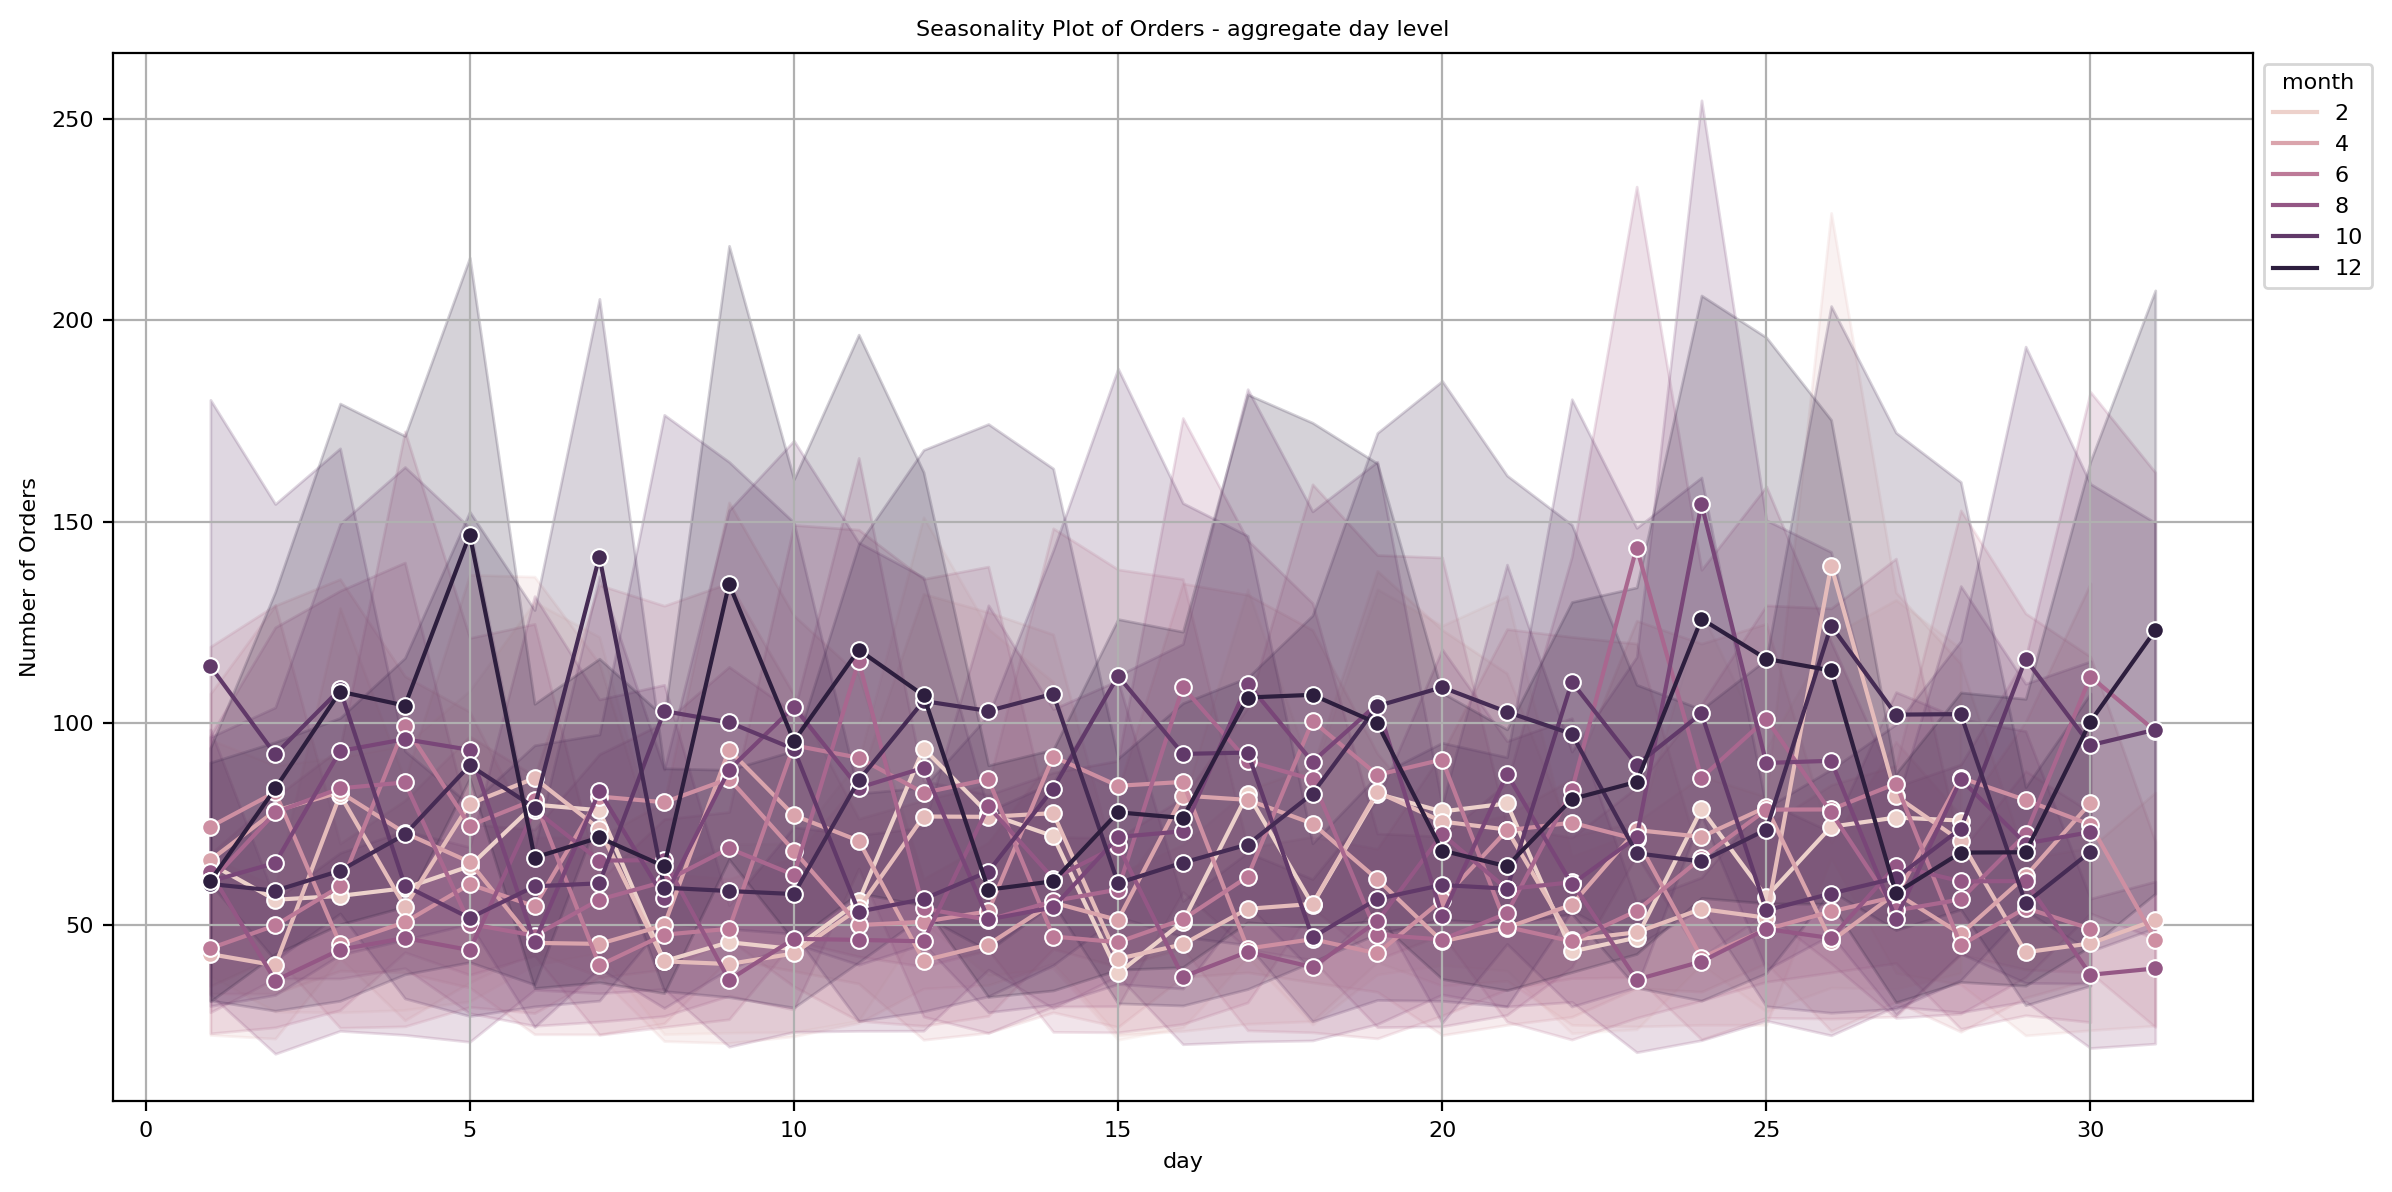

In [30]:
#line plot - day of month by month

df_period = df_orders.copy()
df_period['orders'] = df_period.groupby(by = ['date'])['orders'].transform('sum')
df_period.sort_values(by = ['date'], inplace = True)
df_period.drop_duplicates(subset = ['date'], inplace = True)

# Create a seasonal plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_orders, x='day', y='orders',hue = 'month', marker='o')

plt.title('Seasonality Plot of Orders - aggregate day level')
plt.xlabel('day')
plt.ylabel('Number of Orders')
plt.grid(True)
# plt.xticks(range())  # Set x-axis ticks to show every hour
plt.legend(title='month', loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.tight_layout()
plt.show()

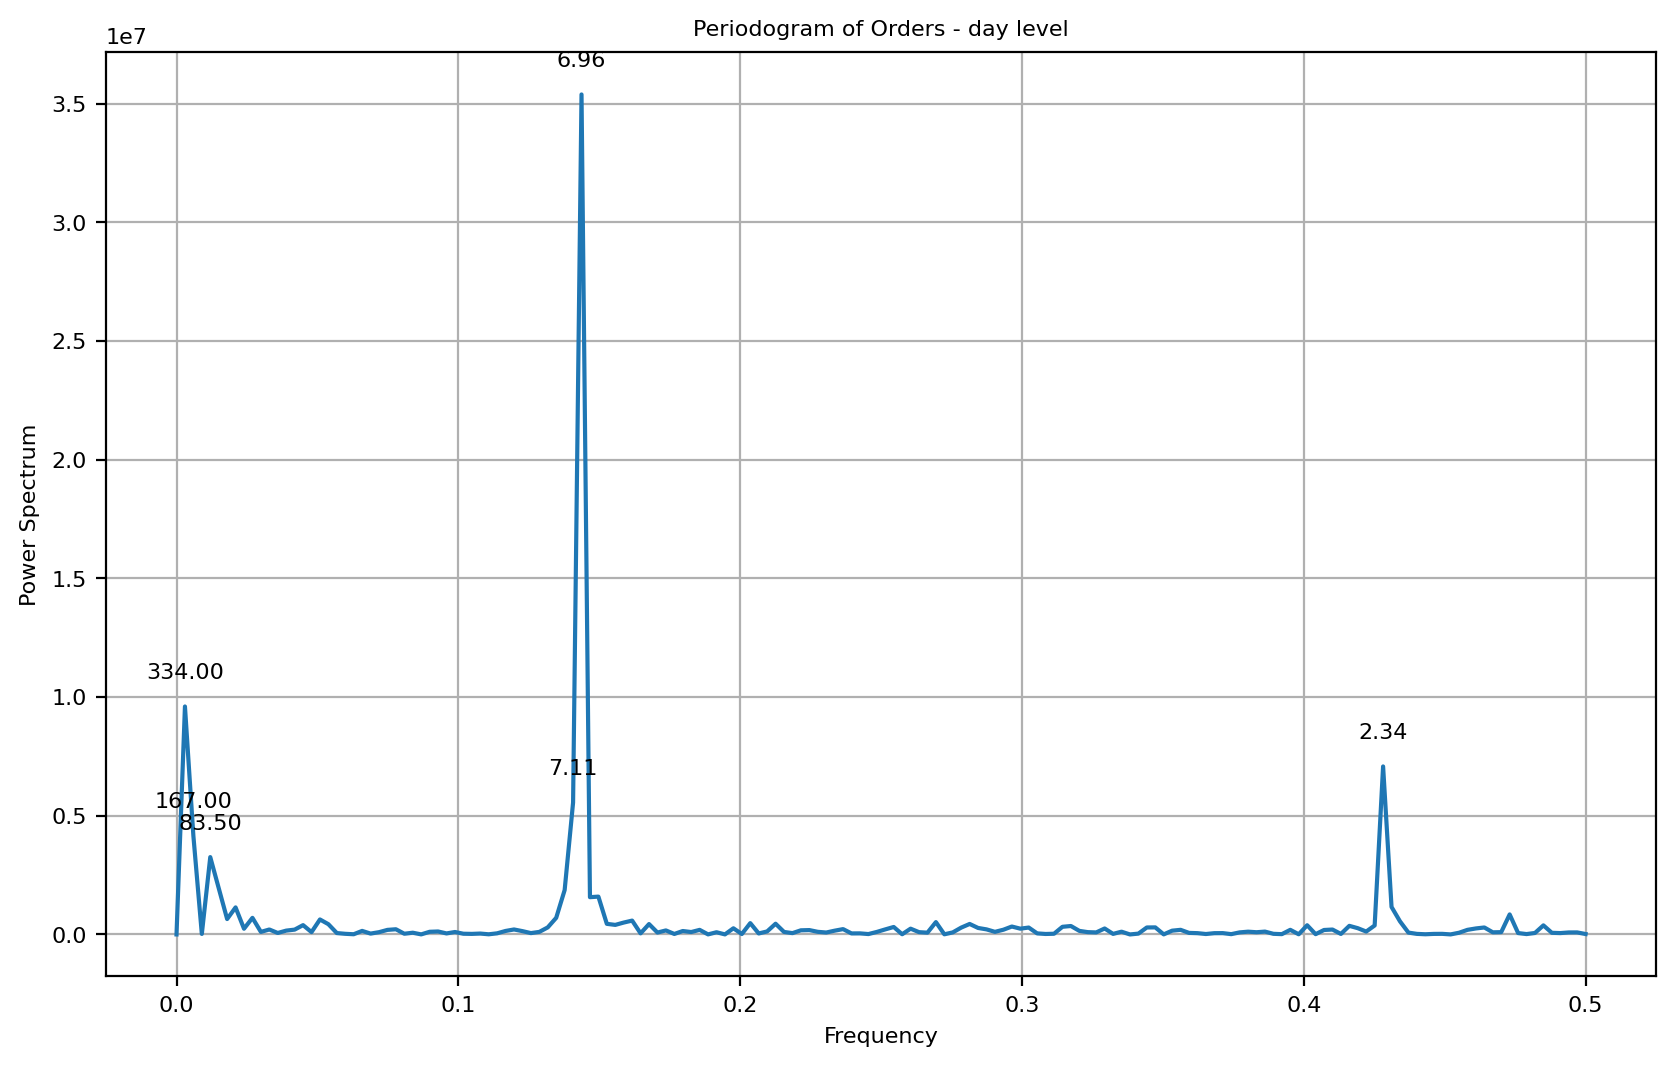

In [31]:
#periodogram: day within year

df_period = df_orders[['date','orders']].copy()
df_period['orders'] = df_period.groupby(by = ['date'])['orders'].transform('sum')
df_period = df_period[['date','orders']].drop_duplicates()

# Set 'time' column as index
df_period.set_index('date', inplace=True)

# Resample data to get hourly counts
hourly_orders = df_period.resample('D').sum()

# Compute periodogram
frequencies, power_spectrum = periodogram(hourly_orders['orders'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_spectrum)
plt.title('Periodogram of Orders - day level')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.grid(True)

# Annotate points where power spectrum > 0.2
for freq, power in zip(frequencies, power_spectrum):
    if power > 0.25*(1e7):
        freq_ = 1/freq
        plt.annotate(f'{freq_:.2f}', (freq, power), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


- Month of Year:

Unsure if we can really attribute behavior as seasonal or to the month of august. There is a strong decrease and then increase after the month of august. Unsure if this is consistent year to year or an outlier. Because we only have data for each month, we don't derive much insight from the periodogram.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


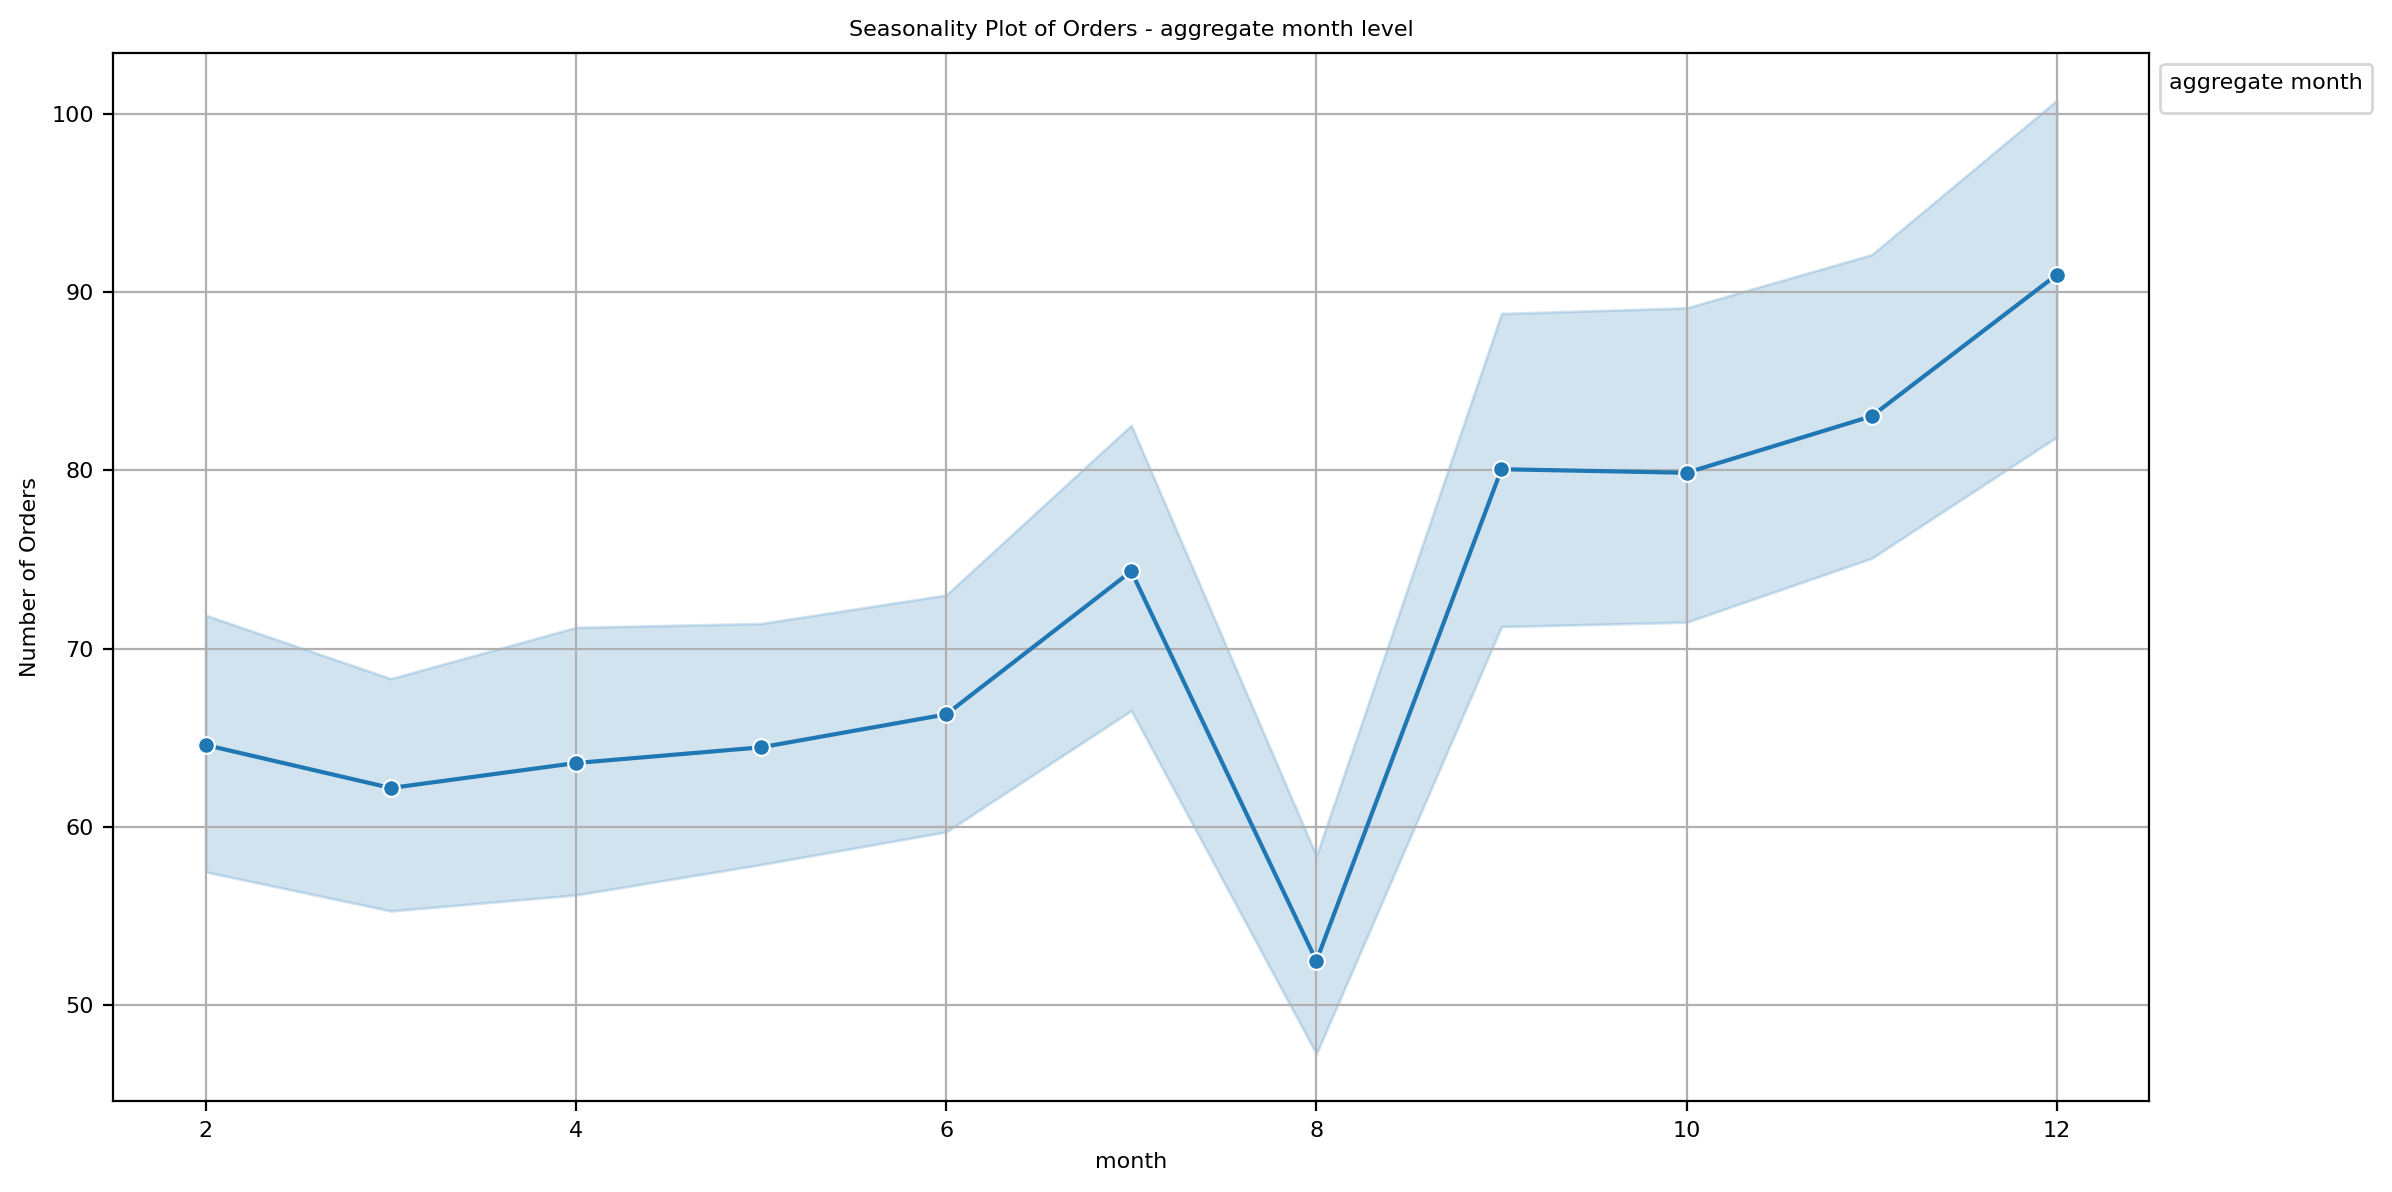

In [32]:
#line plot - month of year

df_period = df_orders.copy()
df_period['orders'] = df_period.groupby(by = ['month'])['orders'].transform('sum')
df_period.sort_values(by = ['date'], inplace = True)
df_period.drop_duplicates(subset = ['month'], inplace = True)

# Create a seasonal plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_orders, x='month', y='orders', marker='o')

plt.title('Seasonality Plot of Orders - aggregate month level')
plt.xlabel('month')
plt.ylabel('Number of Orders')
plt.grid(True)
# plt.xticks(range())  # Set x-axis ticks to show every hour
plt.legend(title='aggregate month', loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.tight_layout()
plt.show()

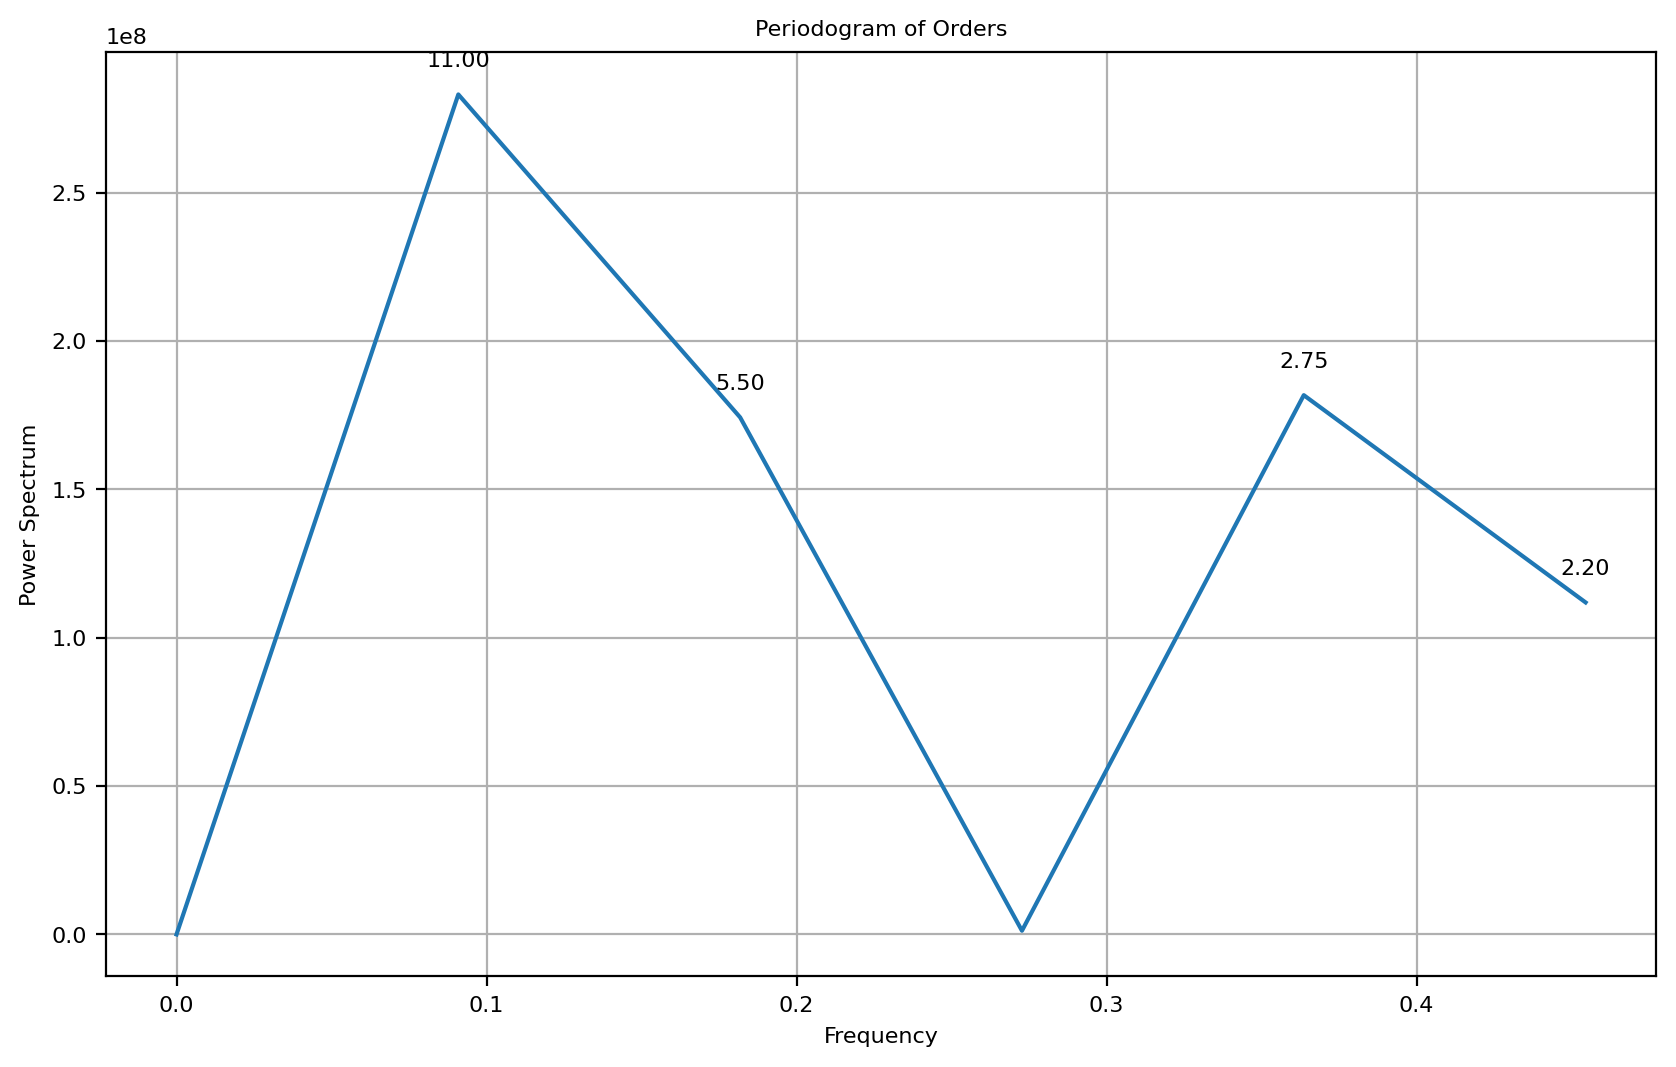

In [33]:
#periodogram - month of year

df_period = df_orders[['month','date','year','orders']].copy()
df_period['orders'] = df_period.groupby(by = ['month','year'])['orders'].transform('sum')
df_period.sort_values(by = ['date'], inplace= True)
df_period.drop_duplicates(subset = ['month','year'], inplace = True)
df_period = df_period[['date','orders']]

# Set 'time' column as index
df_period.set_index('date', inplace=True)

# Resample data to get hourly counts
hourly_orders = df_period.resample('M').sum()

# Compute periodogram
frequencies, power_spectrum = periodogram(hourly_orders['orders'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_spectrum)
plt.title('Periodogram of Orders')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.grid(True)

# Annotate points where power spectrum > 0.2
for freq, power in zip(frequencies, power_spectrum):
    if power > 0.5*(1e8):
        freq_ = 1/freq
        plt.annotate(f'{freq_:.2f}', (freq, power), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

## <a id='part4'>Part 4: EDA - Serial Dependence</a>
- **Objective**: Assess if past order behavior is indicative to future order behavior
- **Tasks:**
  - Deseason-data on the 24 and 168 hour level
  - Evaluate if there is/are cycles present
  - Create autocorrelation and partial correlation plots
  - Create lag plots on different levels and assess correlation
- **Overview**:
  - We found strong correlation between lag-24 (one day previous), lag-168 (one week previous) and lag-336 (two week previous)
  - Although we found a mini cycle in august with regard to a rolling mean, the median did not support the existence of a mini cycle

- De-season order information on the 24-hour, 168-hour level

Using fourier series, we create features that can be used in a linear regression to mimic seasonal behavior on the 24-hour and 168-hour level. We then predict for our time frame and subtract out these predictions to create a de-seasoned order data. Seasonality isn't fully removed but for the purposes of assessing serial dependance and lags we will be able to gain better clarity and correlation.

In [34]:
#Function that removes seasonality from the order information

def remove_seasonality(df_orders):
    df_ = df_orders.copy()

    t = df_['time'].to_numpy()
    y = df_[TARGET].to_numpy()
    df_.set_index('time', inplace = True)

    #24-hour level fourier series
    fourier = Fourier(period=24, order=12)
    X_24 = fourier.in_sample(t)

    #week level fourier series
    fourier_168 = Fourier(period=168, order=60)
    X_168 = fourier_168.in_sample(t)

    X = pd.concat([X_24, X_168], axis=1)

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    y_deseason = (y - y_pred)
    df_orders['orders_deseason'] = y_deseason
    return df_orders


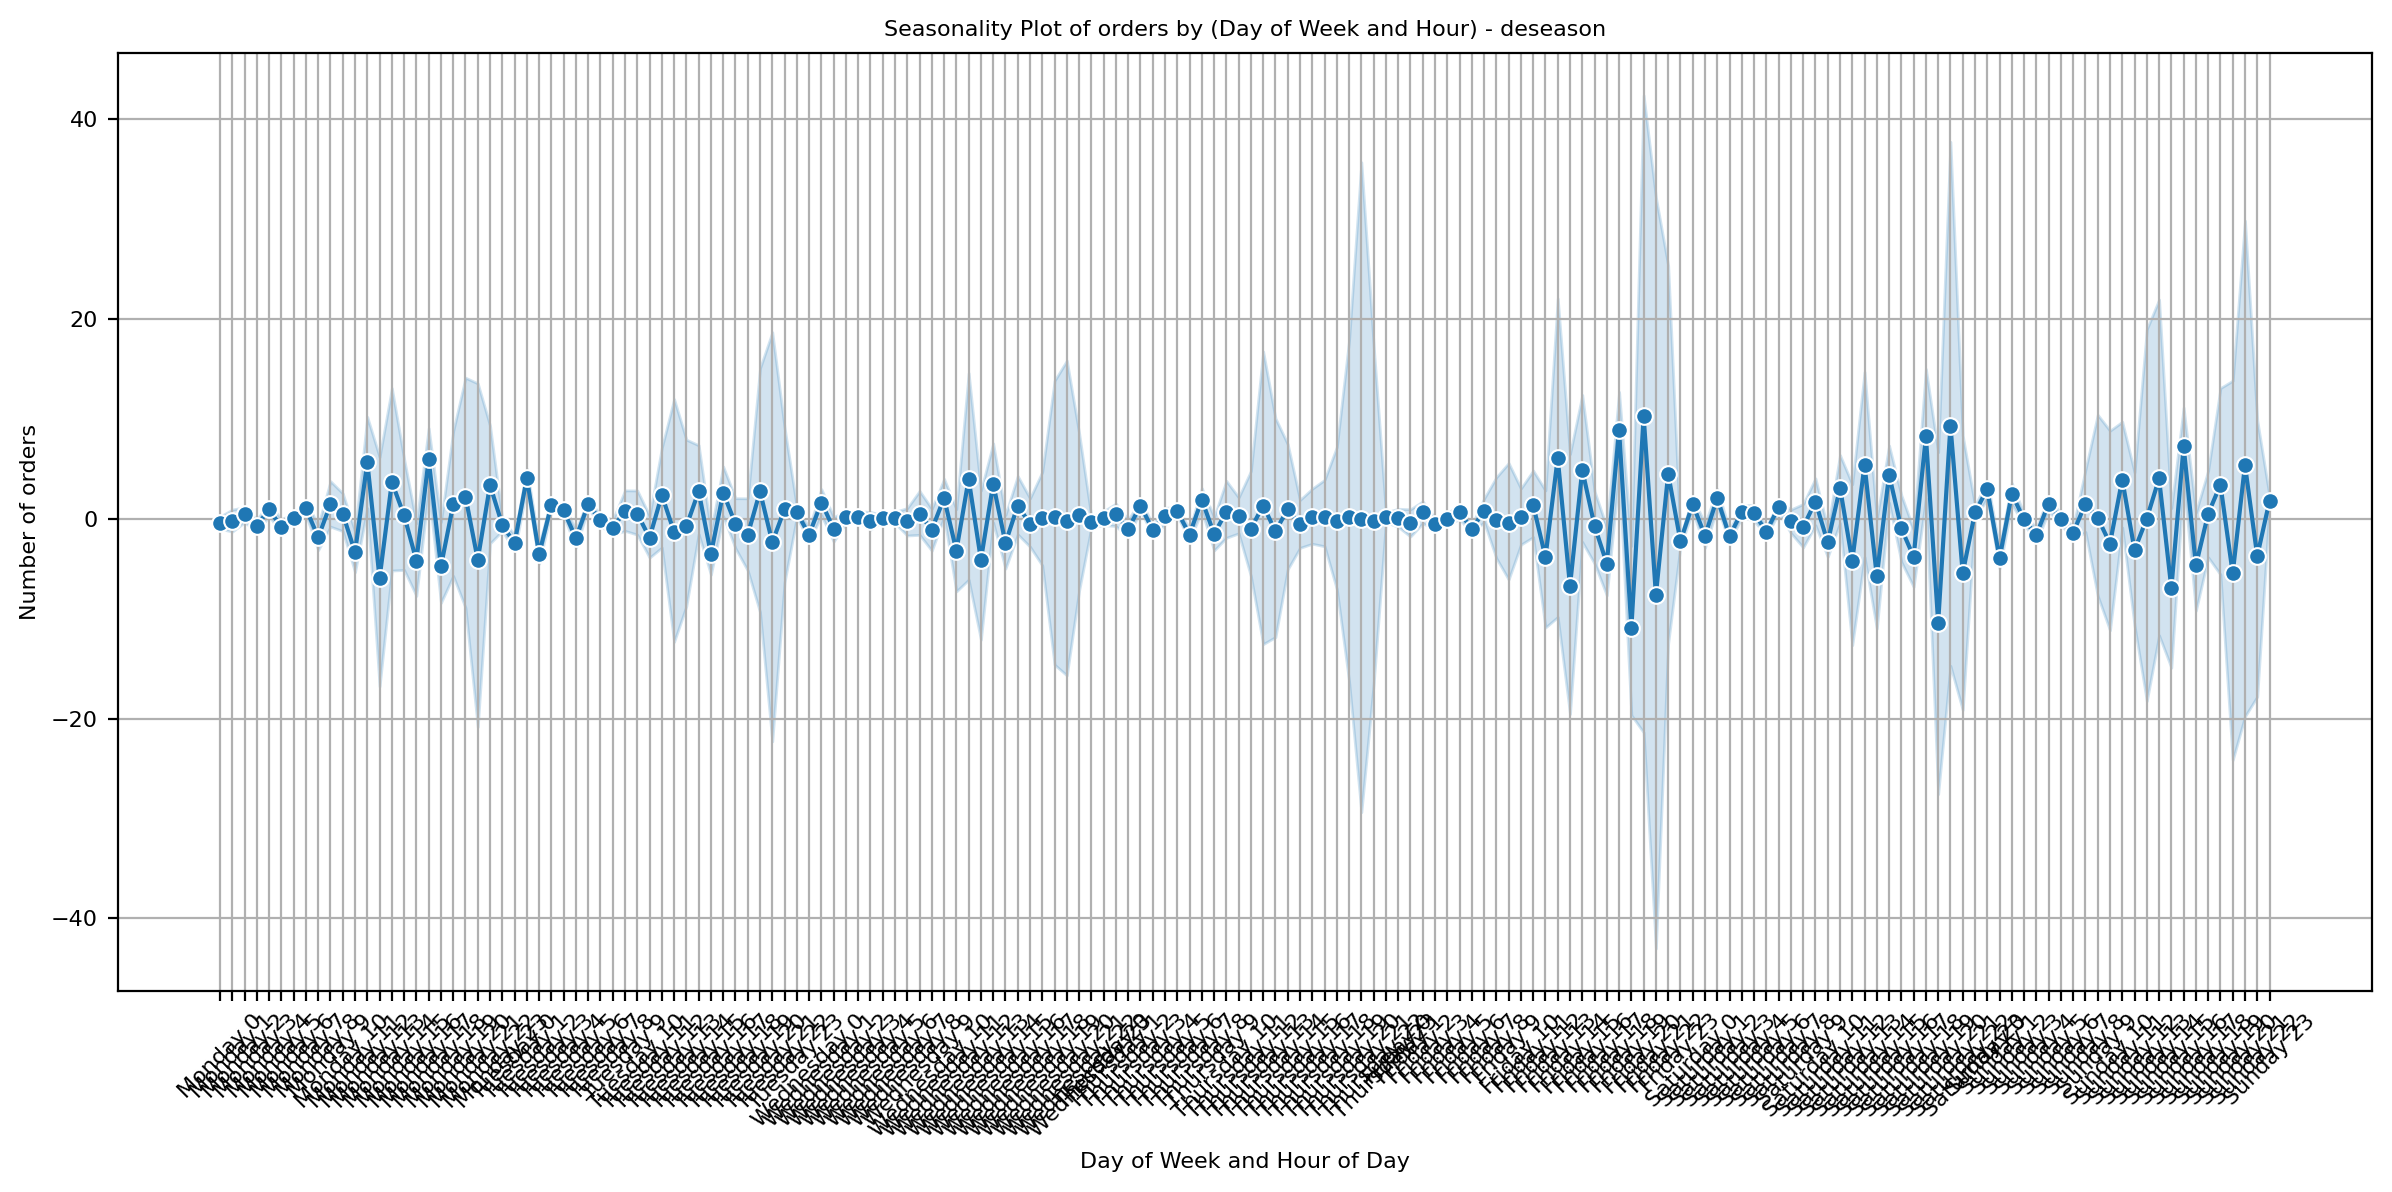

In [35]:
#Remove seasonality from the data

df_orders = remove_seasonality(df_orders)

# Extract day of week and hour from the 'time' column
df_orders['dayofweek'] = df_orders['time'].dt.day_name()
df_orders['hour'] = df_orders['time'].dt.hour

# Create a new column combining day of week and hour
df_orders['day_hour'] = df_orders['dayofweek'] + ' ' + df_orders['hour'].astype(str)

# Create a seasonal plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_orders, x='day_hour', y=TARGET+'_deseason', marker='o')

plt.title('Seasonality Plot of '+TARGET+' by (Day of Week and Hour) - deseason')
plt.xlabel('Day of Week and Hour of Day')
plt.ylabel('Number of '+TARGET)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


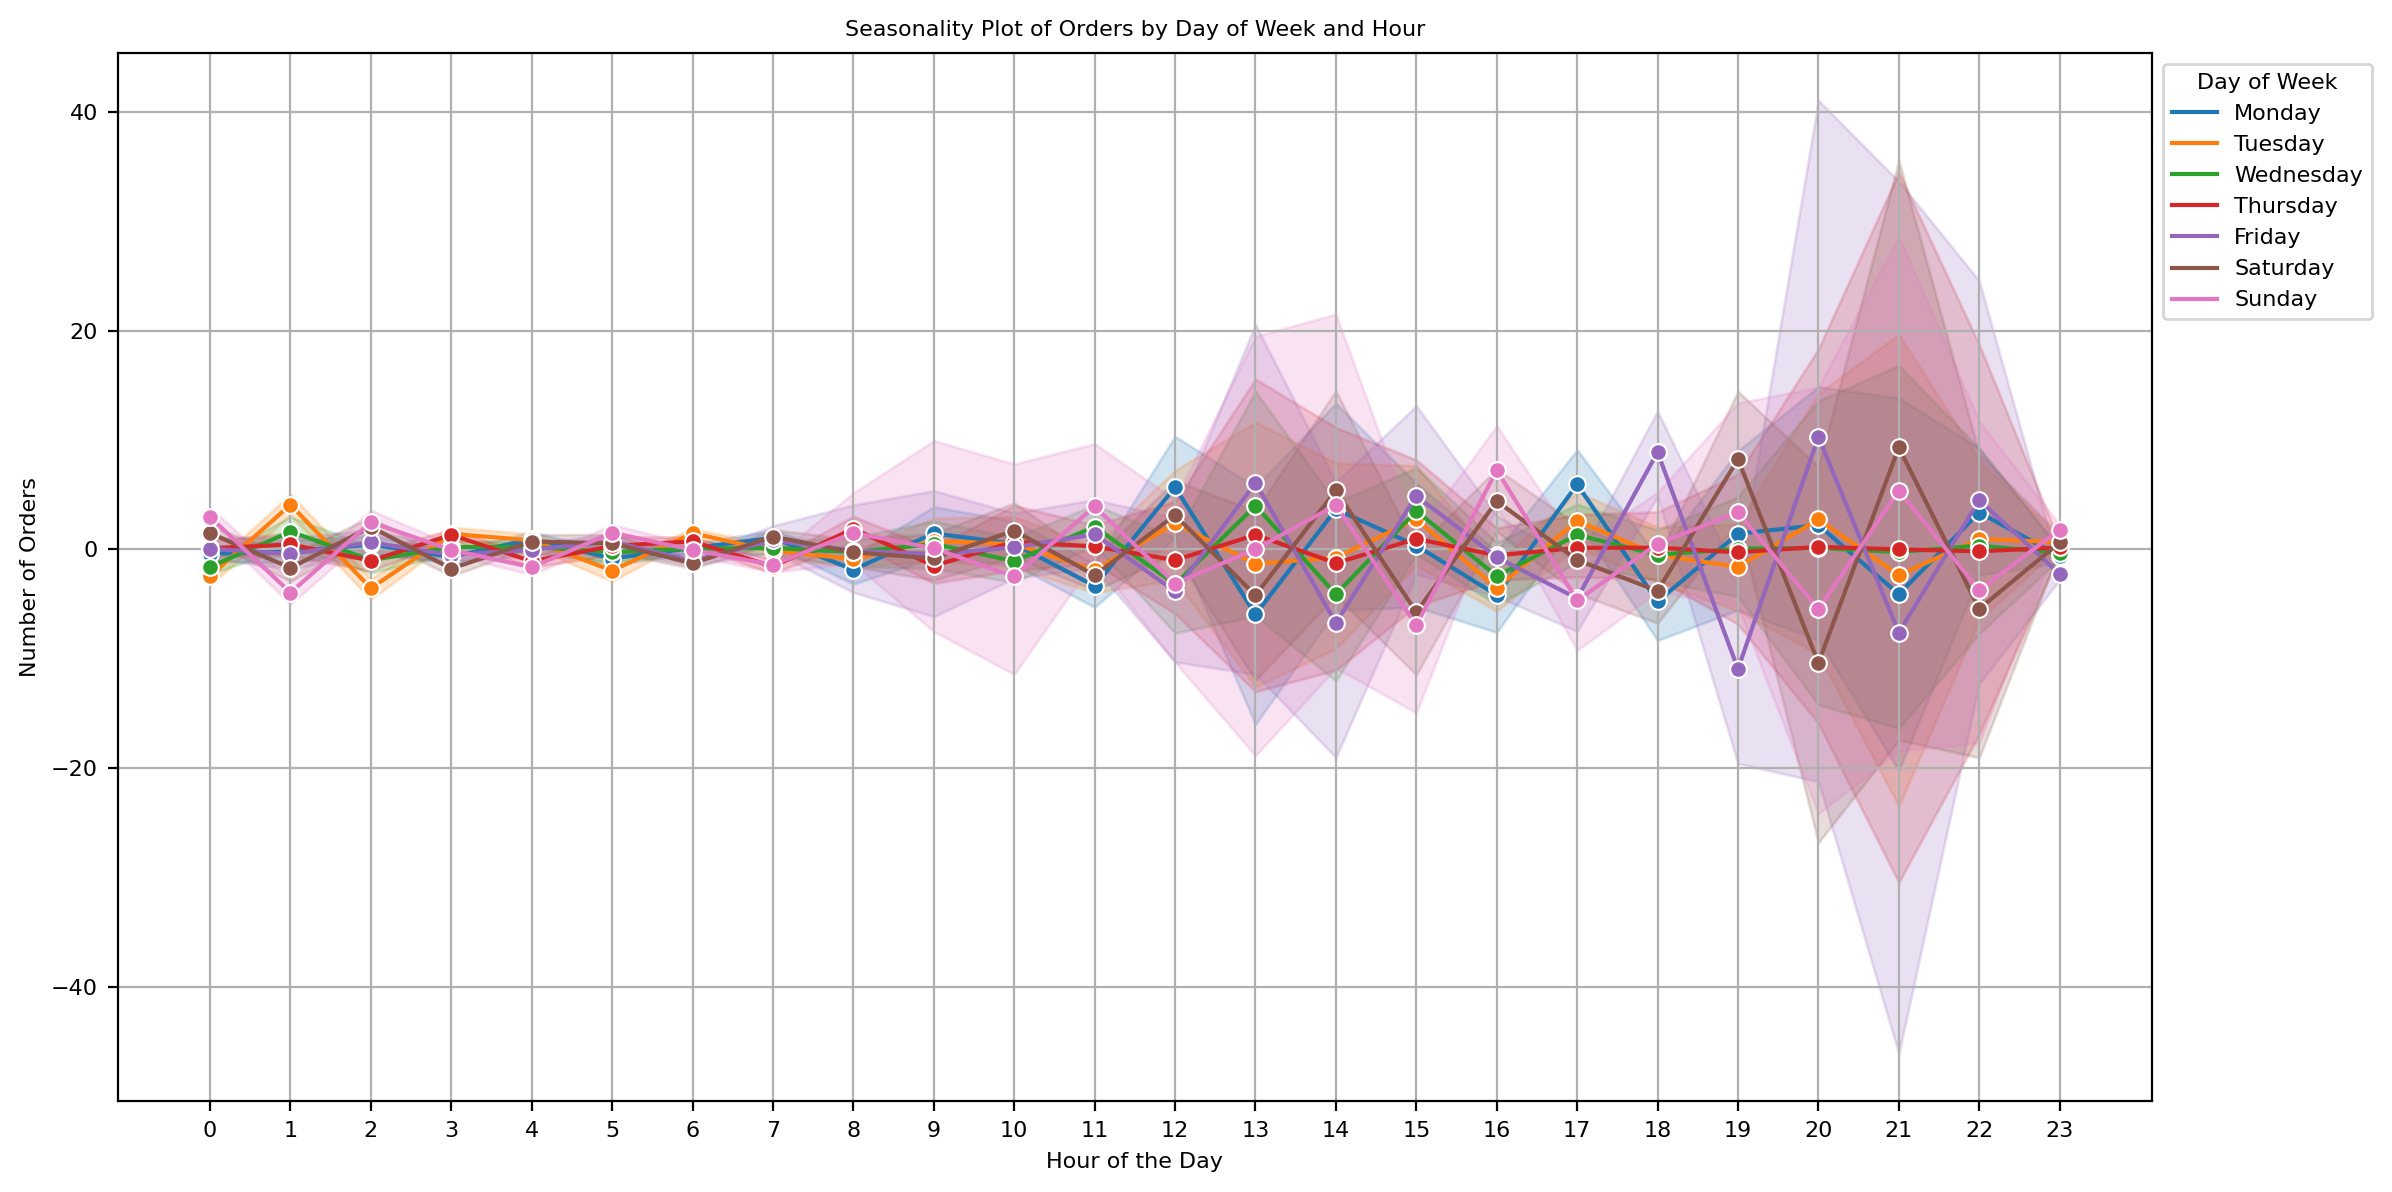

In [36]:
# Extract day of week and hour from the 'time' column
df_orders['dayofweek'] = df_orders['time'].dt.day_name()
df_orders['hour'] = df_orders['time'].dt.hour

# Create a seasonal plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_orders, x='hour', y=TARGET+'_deseason', hue='dayofweek', marker='o')

plt.title('Seasonality Plot of Orders by Day of Week and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.xticks(range(24))  # Set x-axis ticks to show every hour
plt.legend(title='Day of Week', loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.tight_layout()
plt.show()


- Evaluate if there is/are cycles present

Based on the median, we're not seeing a cycle but based on the mean we're seeing maybe the tiniest cycle appearing in the month of august. We saw this previously when looking at month level seasonality. We can account for this behavior using a deseasoned rolling mean.

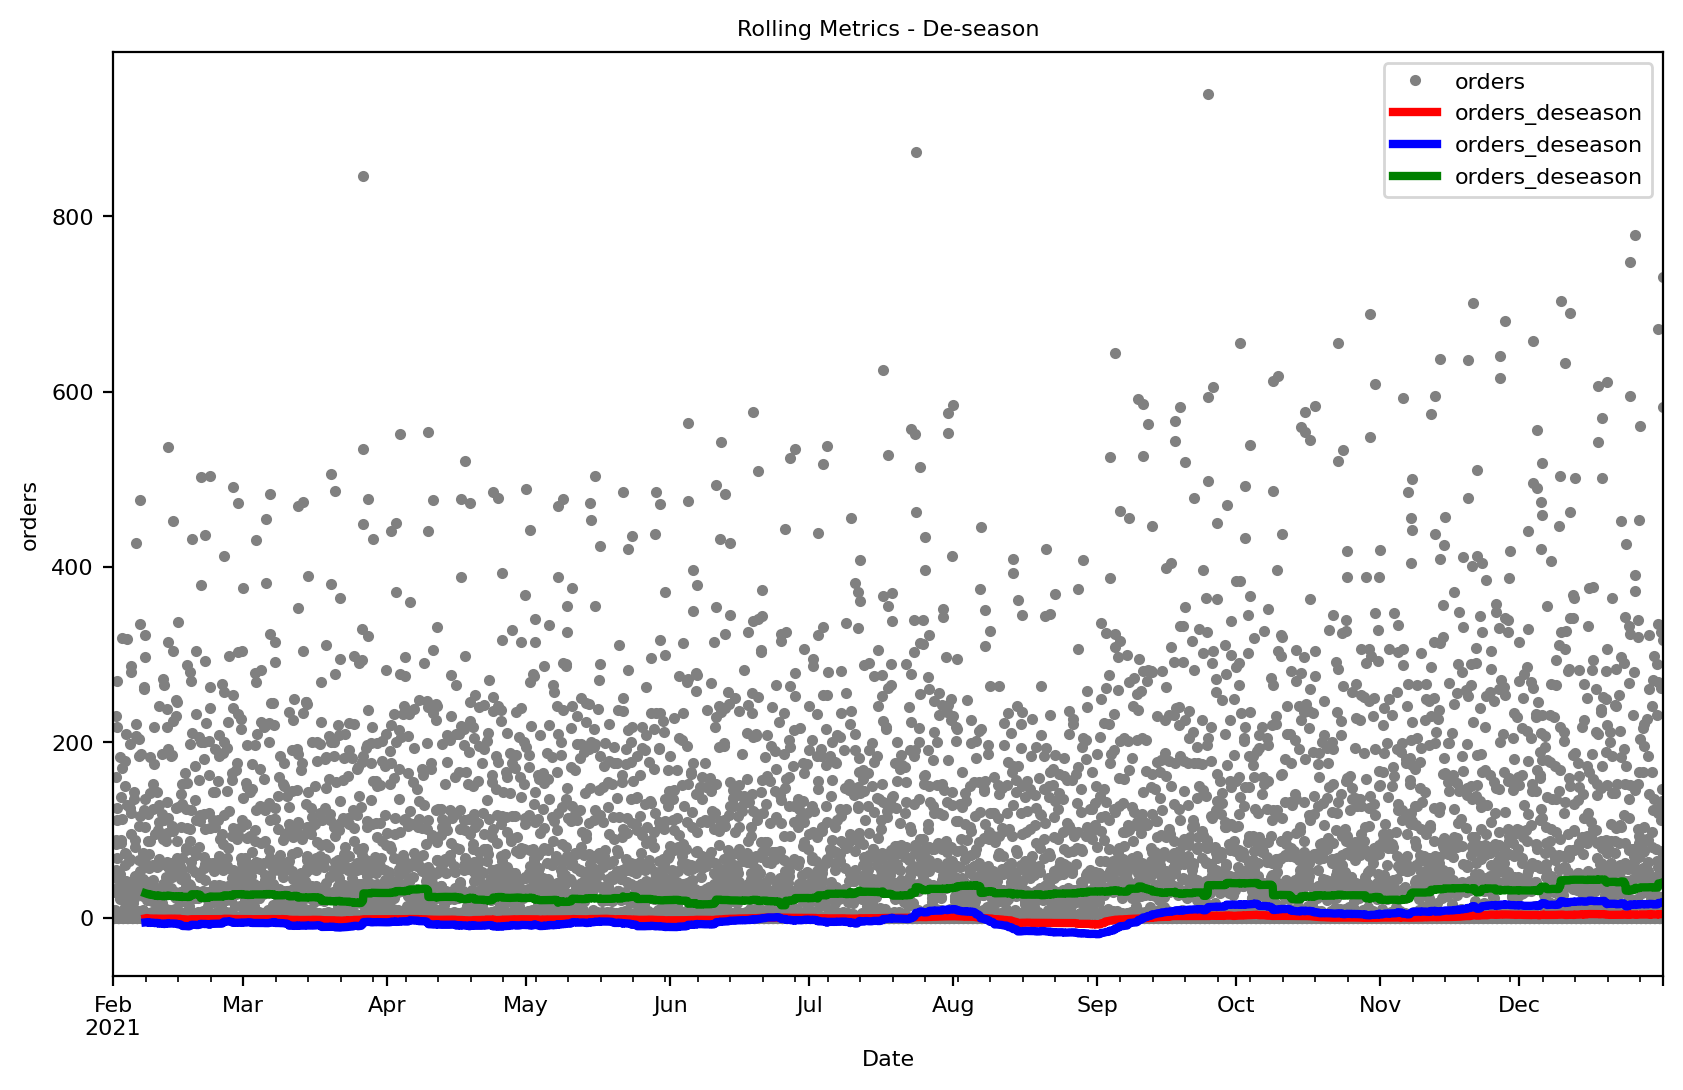

In [37]:
df_orders_time = df_orders.set_index('time')
rolling_window = df_orders_time[[TARGET+'_deseason']].rolling(
    window=336,       # two weeks
    center=False,       
    min_periods=168,   # 168 = 24*7 (one week)
)

moving_median = rolling_window.median()  # Compute the median
moving_mean = rolling_window.mean()      # Compute the mean
moving_std = rolling_window.std()      # Compute the mean

# Plotting
ax = df_orders_time[[TARGET]].plot(style=".", color="0.5", figsize=(10, 6))
moving_median.plot(ax=ax, linewidth=3, color='red', legend=True, label='Rolling Median')
moving_mean.plot(ax=ax, linewidth=3, color='blue', legend=True, label='Rolling Mean')
moving_std.plot(ax=ax, linewidth=3, color='green', legend=True, label='Rolling STD')
ax.set_title("Rolling Metrics - De-season")
ax.set_xlabel("Date")  # Assuming the index of df_orders_time is some datetime type
ax.set_ylabel(TARGET)

plt.show()

- Autocorrelation plot

We are seeing strong lag relationships in multiple 24 hour previous chunks of time, consistent with the recurrent seasonal behavior we would expect that we saw previously.

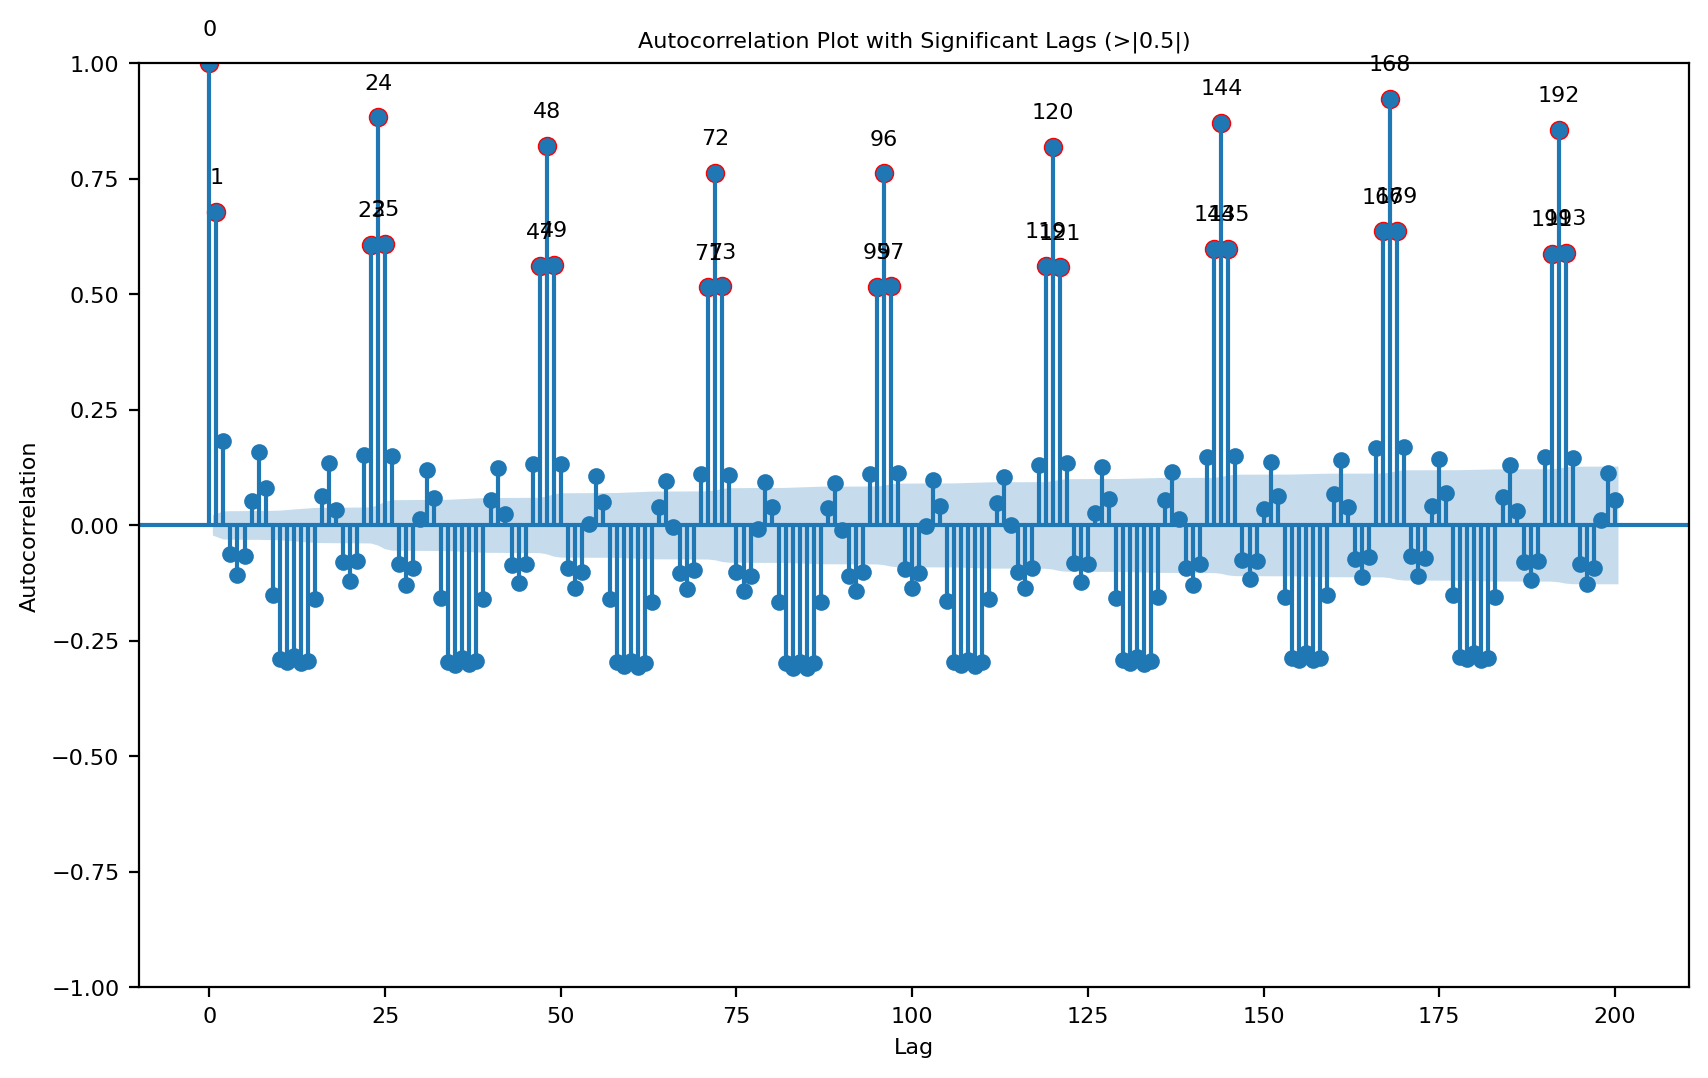

In [38]:
#Autocorrelation - full data as is

# Extract the time series data
df_corr = df_orders[['time', TARGET]].copy()
df_corr.set_index('time', inplace=True)

# Calculate the autocorrelation function
acf_values = acf(df_corr[TARGET], nlags=200)

# Filter the lags where the autocorrelation is greater than 0.2
significant_lags = [lag for lag, acf in enumerate(acf_values) if abs(acf) > 0.5]

# Create a new plot displaying only significant lags
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(df_corr, lags=200, ax=ax)  # Re-plot with confidence interval
plt.scatter(significant_lags, [acf_values[lag] for lag in significant_lags], color='red', marker='o')

# Annotate each significant lag point with its lag value
for lag in significant_lags:
    plt.annotate(f'{lag}', (lag, acf_values[lag]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot with Significant Lags (>|0.5|)')
plt.show()

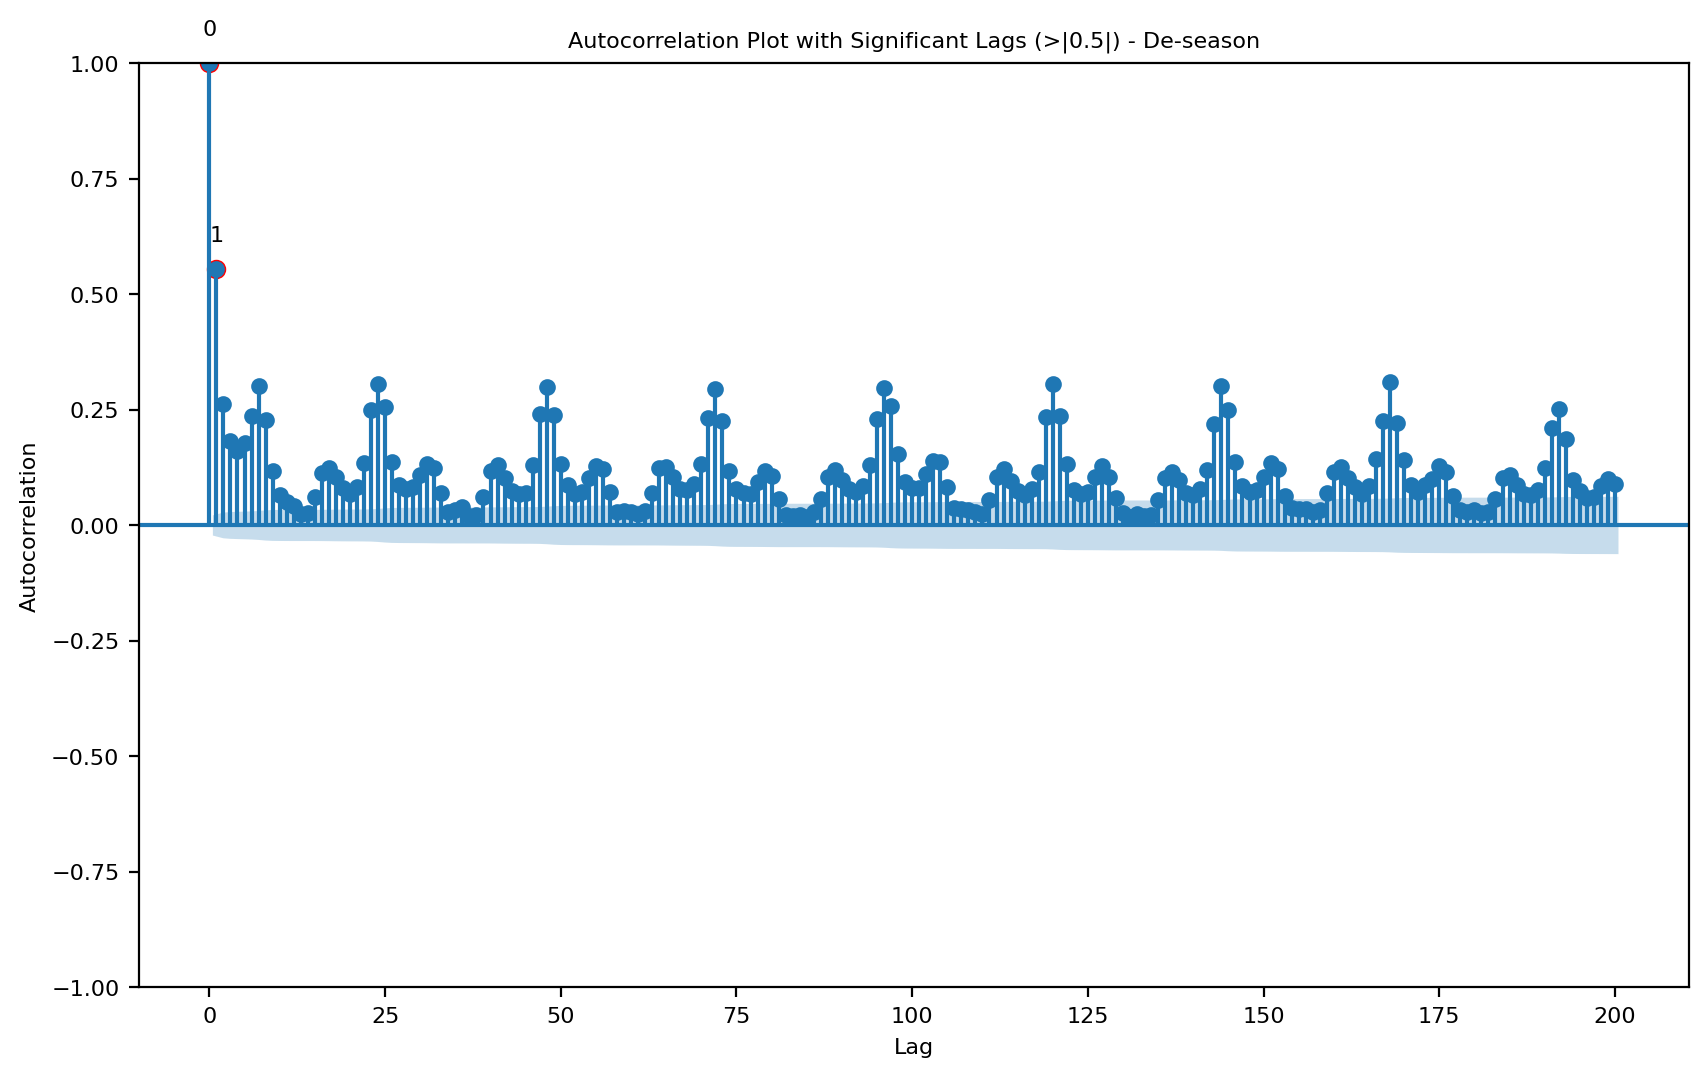

In [39]:
#De-season - autocorrelation

# Extract the time series data
df_corr = df_orders[['time', TARGET+'_deseason']].copy()
df_corr.set_index('time', inplace=True)

# Calculate the autocorrelation function
acf_values = acf(df_corr[TARGET+'_deseason'], nlags=200)

# Filter the lags where the autocorrelation is greater than 0.2
significant_lags = [lag for lag, acf in enumerate(acf_values) if abs(acf) > 0.5]

# Create a new plot displaying only significant lags
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(df_corr, lags=200, ax=ax)  # Re-plot with confidence interval
plt.scatter(significant_lags, [acf_values[lag] for lag in significant_lags], color='red', marker='o')

# Annotate each significant lag point with its lag value
for lag in significant_lags:
    plt.annotate(f'{lag}', (lag, acf_values[lag]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot with Significant Lags (>|0.5|) - De-season')
plt.show()


- Partial Autocorrelation

Here we're seeing that most of this correlation can be covered by a 24 hour lag or a 168 hour lag.

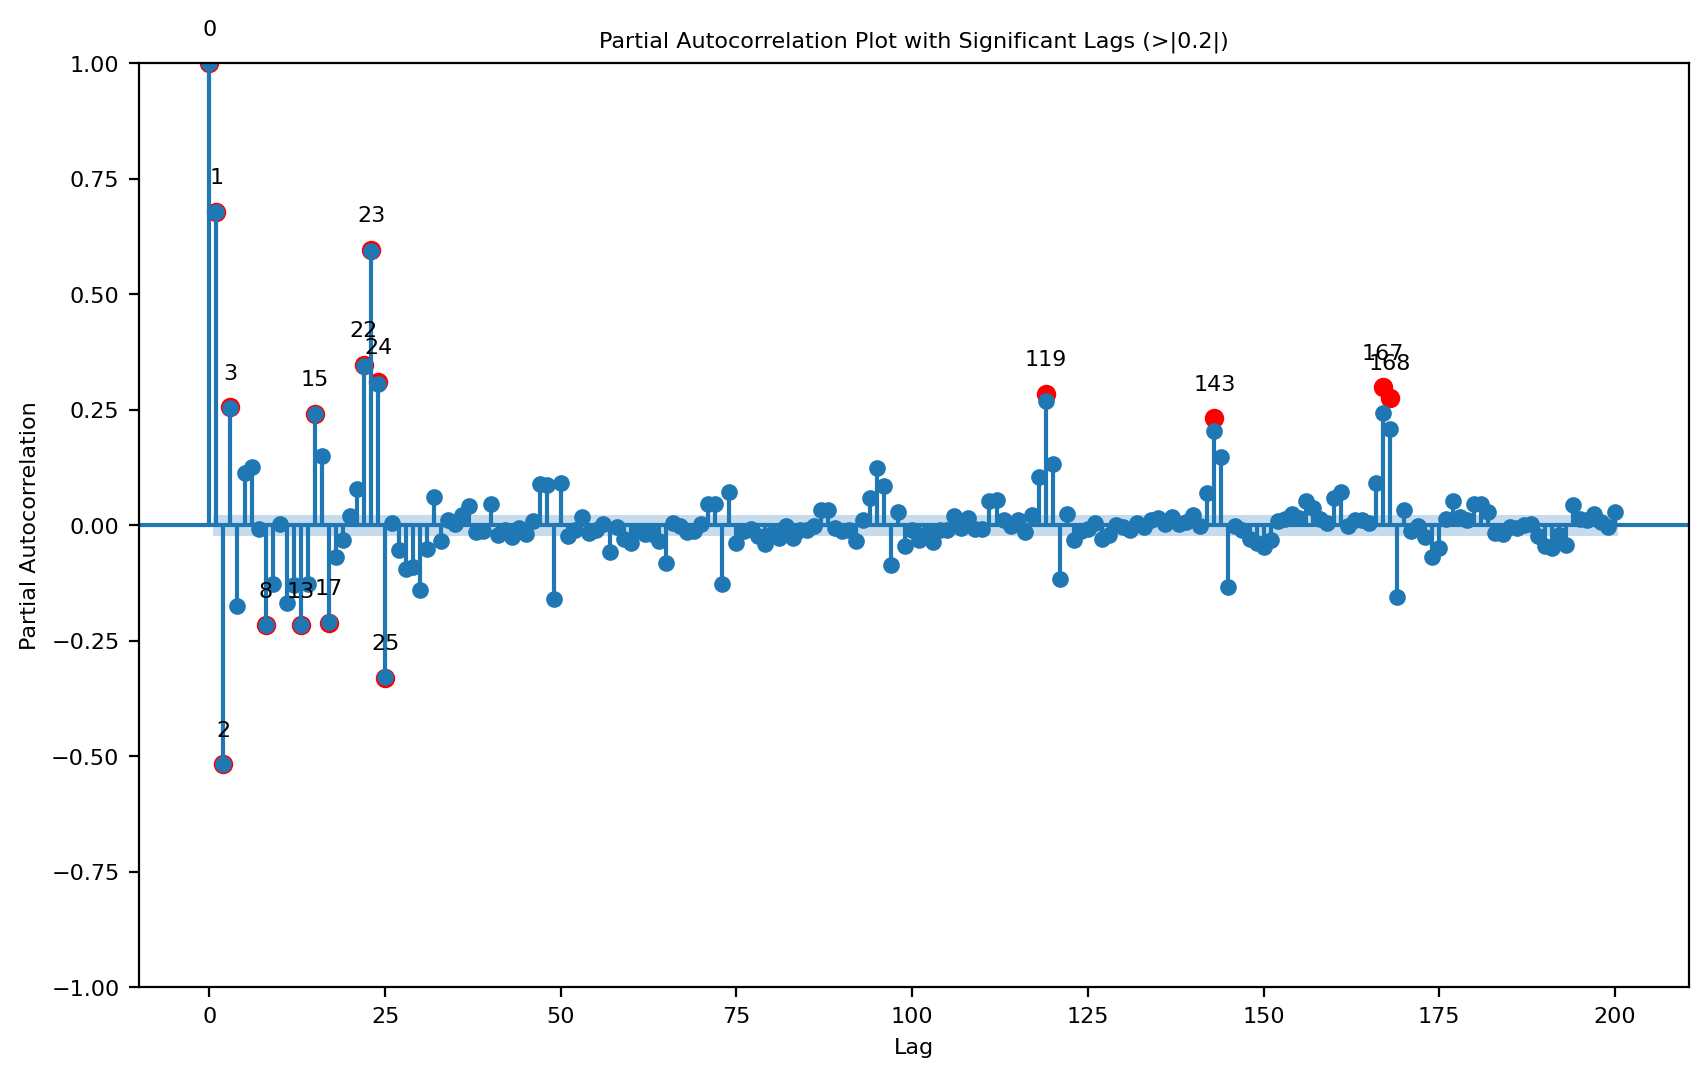

In [40]:
#partial autocorrelation - full data as is

# Extract the time series data
df_corr = df_orders[['time', TARGET]].copy()
df_corr.set_index('time', inplace=True)

# Calculate the partial autocorrelation function
pacf_values = pacf(df_corr[TARGET], nlags=200)

# Filter the lags where the partial autocorrelation is greater than 0.2
significant_lags = [lag for lag, pacf in enumerate(pacf_values) if abs(pacf) > 0.2]

# Create a new plot displaying only significant lags
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df_corr, lags=200, alpha=0.05, ax=ax)  # Re-plot with confidence interval
plt.scatter(significant_lags, [pacf_values[lag] for lag in significant_lags], color='red', marker='o')

# Annotate each significant lag point with its lag value
for lag in significant_lags:
    plt.annotate(f'{lag}', (lag, pacf_values[lag]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot with Significant Lags (>|0.2|)')
plt.show()

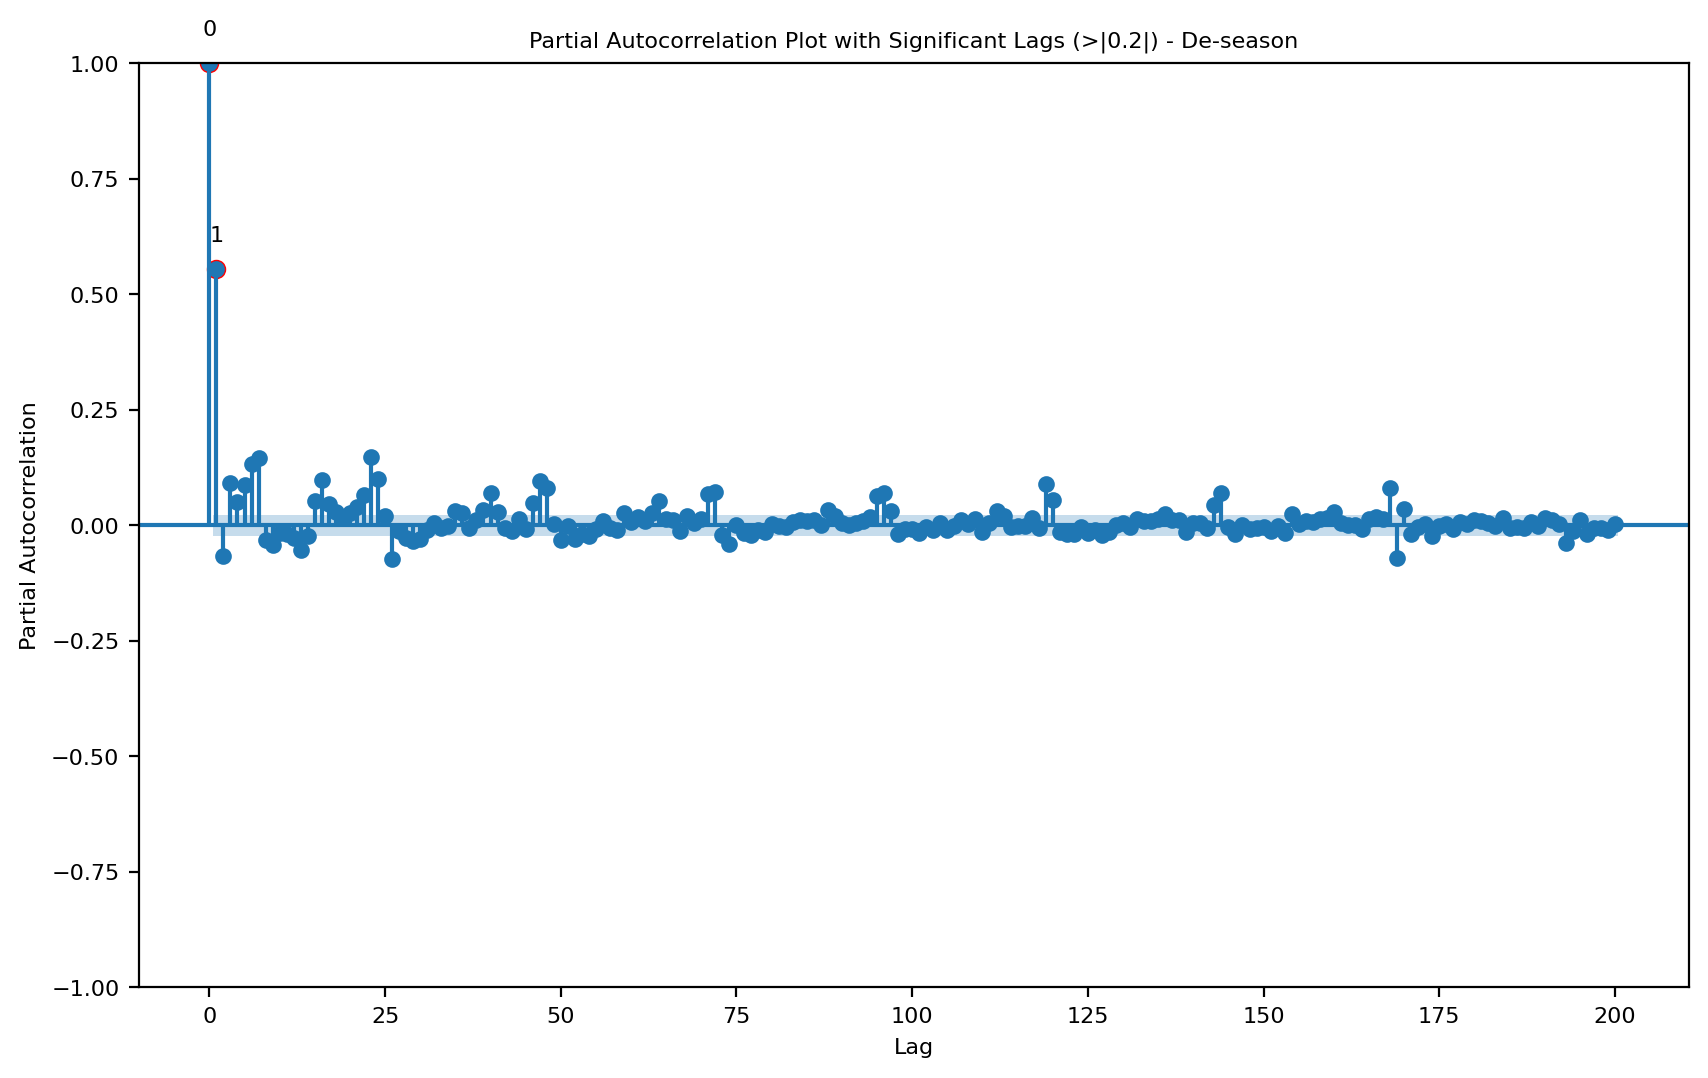

In [41]:
#partial autocorrelation - deseason

# Extract the time series data
df_corr = df_orders[['time', TARGET+'_deseason']].copy()
df_corr.set_index('time', inplace=True)

# Calculate the partial autocorrelation function
pacf_values = pacf(df_corr[TARGET+'_deseason'], nlags=200)

# Filter the lags where the partial autocorrelation is greater than 0.2
significant_lags = [lag for lag, pacf in enumerate(pacf_values) if abs(pacf) > 0.2]

# Create a new plot displaying only significant lags
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df_corr, lags=200, alpha=0.05, ax=ax)  # Re-plot with confidence interval
plt.scatter(significant_lags, [pacf_values[lag] for lag in significant_lags], color='red', marker='o')

# Annotate each significant lag point with its lag value
for lag in significant_lags:
    plt.annotate(f'{lag}', (lag, pacf_values[lag]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot with Significant Lags (>|0.2|) - De-season')
plt.show()


- Lag plot - 24 hour lag (day previous)

lag_24
[[0.8908058]]
[7.89991526]


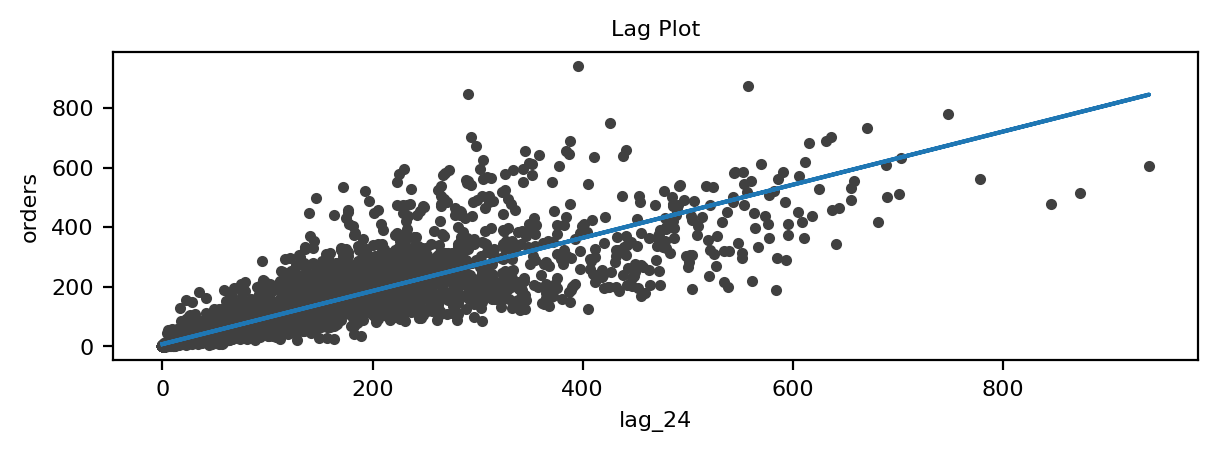

In [42]:
#lag plot - 24 hour lag (day previous)

lag_var = 'lag_24'

X = df_orders[['time',TARGET]].copy()

for i in range(1,32):
    X['lag_'+str(i)] = X['orders'].shift(i)
i = 48
X['lag_'+str(i)] = X['orders'].shift(i)
i = 168
X['lag_'+str(i)] = X['orders'].shift(i)
i = 167
X['lag_'+str(i)] = X['orders'].shift(i)
i = 169
X['lag_'+str(i)] = X['orders'].shift(i)
X.dropna(inplace = True)
X.set_index('time',inplace = True)
y = X[[TARGET]]  # the target
X.drop(columns = ['orders'], inplace = True)

X = X[[lag_var]]

model = LinearRegression()
model.fit(X, y)

print(lag_var)
print(model.coef_)
print(model.intercept_)

y_pred = pd.Series(model.predict(X).flatten(), index=X.index)

fig, ax = plt.subplots()
ax.plot(X[lag_var].values, y.values, '.', color='0.25')
ax.plot(X[lag_var].values, y_pred.values)
ax.set_ylabel('orders')
ax.set_xlabel(lag_var)
ax.set_title('Lag Plot');

- Lag plot - 168 hour lag (week previous)

lag_168
[[0.95922372]]
[3.4505404]


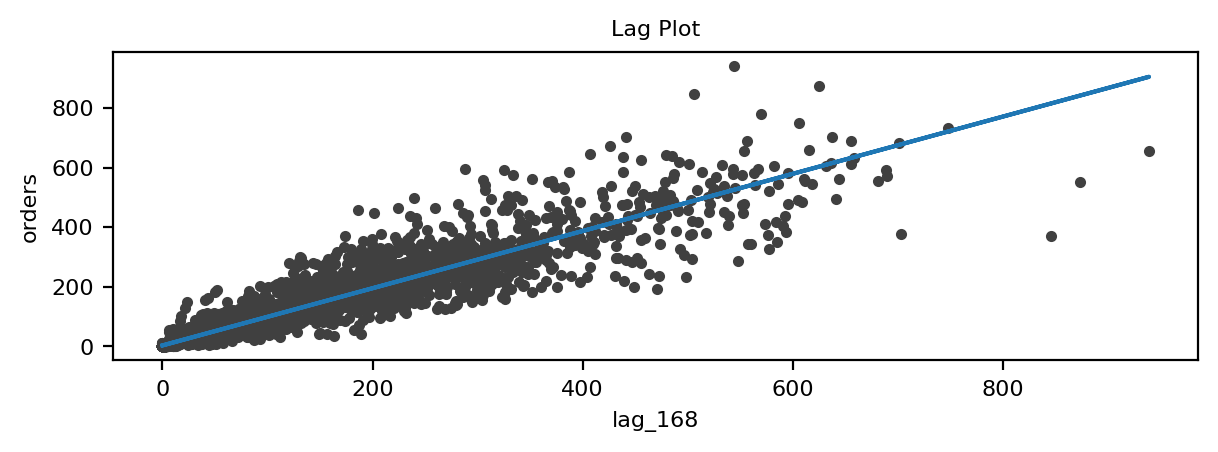

In [43]:
#lag plot - 168 hour lag (week previous)

lag_var = 'lag_168'

X = df_orders[['time','orders']].copy()

for i in range(1,32):
    X['lag_'+str(i)] = X['orders'].shift(i)
i = 48
X['lag_'+str(i)] = X['orders'].shift(i)
i = 168
X['lag_'+str(i)] = X['orders'].shift(i)
i = 167
X['lag_'+str(i)] = X['orders'].shift(i)
i = 169
X['lag_'+str(i)] = X['orders'].shift(i)
X.dropna(inplace = True)
X.set_index('time',inplace = True)
y = X[[TARGET]]  # the target
X.drop(columns = ['orders'], inplace = True)

X = X[[lag_var]]

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression()
model.fit(X, y)

print(lag_var)
print(model.coef_)
print(model.intercept_)

y_pred = pd.Series(model.predict(X).flatten(), index=X.index)

fig, ax = plt.subplots()
ax.plot(X[lag_var].values, y.values, '.', color='0.25')
ax.plot(X[lag_var].values, y_pred.values)
ax.set_ylabel('orders')
ax.set_xlabel(lag_var)
ax.set_title('Lag Plot');

- Lag plot - 336 hour lag (two week previous)

lag_336
[[0.96274393]]
[3.83165109]


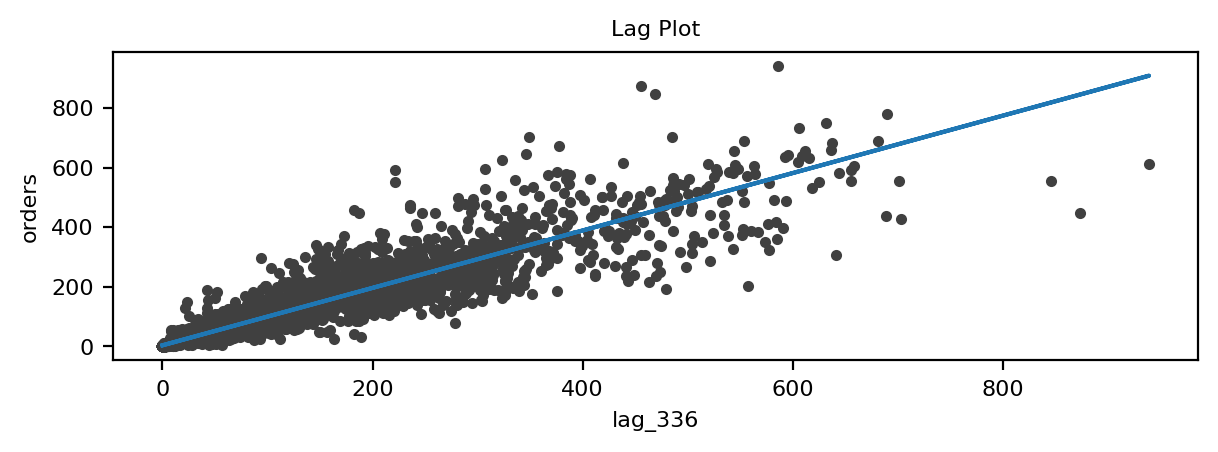

In [44]:
#lag plot - 336 hour lag (two week previous)

lag_var = 'lag_336'

X = df_orders[['time','orders']].copy()

for i in range(1,32):
    X['lag_'+str(i)] = X['orders'].shift(i)
i = 48
X['lag_'+str(i)] = X['orders'].shift(i)
i = 168
X['lag_'+str(i)] = X['orders'].shift(i)
i = 167
X['lag_'+str(i)] = X['orders'].shift(i)
i = 169
X['lag_'+str(i)] = X['orders'].shift(i)
i = 336
X['lag_'+str(i)] = X['orders'].shift(i)
X.dropna(inplace = True)
X.set_index('time',inplace = True)
y = X[[TARGET]]  # the target
X.drop(columns = ['orders'], inplace = True)

X = X[[lag_var]]

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression()
model.fit(X, y)

print(lag_var)
print(model.coef_)
print(model.intercept_)

y_pred = pd.Series(model.predict(X).flatten(), index=X.index)

fig, ax = plt.subplots()
ax.plot(X[lag_var].values, y.values, '.', color='0.25')
ax.plot(X[lag_var].values, y_pred.values)
ax.set_ylabel('orders')
ax.set_xlabel(lag_var)
ax.set_title('Lag Plot');

## <a id='part5'>Part 5: Feature Creation</a>
- **Objective**: Based on EDA create features to be used in predicting orders
- **Tasks:**
  - Lag features
  - Seasonality features: fourier series
  - One hot encoded features: day of week
  - Rolling window features
- **Overview:**
  - We created functions to create dataframes to store the features we will use to build models with. We created two lag features (168-hour previous week and 336-hour previous two week), two types of fourier series (24-seasonality based and 168-seasonality based), and one hot encoded the day of the week. We created a feature for the mini cycle we saw in august but it lead to worse model performance so it was moved into its own function yet left unused.
  

In [45]:
#functions to create features for linear regression

def create_features_train(df_in, col_include):
    df_ = df_in.copy()

    #Lag features
    df_['lag_168'] = df_['orders'].shift(168)
    df_['lag_336'] = df_['orders'].shift(336)
    col_include.append('lag_168')
    col_include.append('lag_336')
    df_.dropna(inplace = True)
    df_.reset_index(drop = True, inplace = True)

    #Seasonality features
    df_['dayofweek'] = df_['time'].dt.day_of_week
    df_['hour'] = df_['time'].dt.hour

    #one hot encode day of week
    for day in df_['dayofweek'].unique().tolist():
        df_['ohe_'+str(day)] = 0
        df_.loc[df_['dayofweek']==day, 'ohe_'+str(day)] = 1
        col_include.append('ohe_'+str(day))

    t = df_['time'].to_numpy()

    #24-hour level fourier series
    fourier = Fourier(period=24, order=12)
    X_24 = fourier.in_sample(t)

    #week level fourier series
    fourier_168 = Fourier(period=168, order=60)
    X_168 = fourier_168.in_sample(t)

    #concat all features together
    df_.set_index('time', inplace = True)
    y_train = df_[TARGET].to_numpy()
    df_train = pd.concat([X_24, X_168, df_[col_include]], axis=1)

    return df_train, y_train

def create_features_train_w_cycle(df_in, col_include):
    df_ = df_in.copy()

    #Lag features
    df_['lag_168'] = df_['orders'].shift(168)
    df_['lag_336'] = df_['orders'].shift(336)
    col_include.append('lag_168')
    col_include.append('lag_336')

    #Seasonality features
    df_['dayofweek'] = df_['time'].dt.day_of_week
    df_['hour'] = df_['time'].dt.hour

    #one hot encode day of week
    for day in df_['dayofweek'].unique().tolist():
        df_['ohe_'+str(day)] = 0
        df_.loc[df_['dayofweek']==day, 'ohe_'+str(day)] = 1
        col_include.append('ohe_'+str(day))

    t = df_['time'].to_numpy()

    #24-hour level fourier series
    fourier = Fourier(period=24, order=12)
    X_24 = fourier.in_sample(t)

    #week level fourier series
    fourier_168 = Fourier(period=168, order=60)
    X_168 = fourier_168.in_sample(t)

    #Cycle
    #deseason orders and calc rolling mean and rolling median
    df_deseason = df_.copy()
    df_deseason = remove_seasonality(df_deseason)
    df_deseason.set_index('time', inplace = True)

    rolling_window = df_deseason[[TARGET+'_deseason']].rolling(
        window=336,       # two weeks
        center=False,       
        min_periods=168,   # 168 = 24*7 (one week)
    )

    moving_median = rolling_window.median()  # Compute the median
    moving_mean = rolling_window.mean()      # Compute the mean

    df_deseason['rolling_median'] = moving_median['orders_deseason']
    df_deseason['rolling_mean'] = moving_mean['orders_deseason']

    #concat all features together
    df_.set_index('time', inplace = True)
    df_train = pd.concat([X_24, X_168, df_[col_include], df_deseason[['rolling_median','rolling_mean',TARGET]]], axis=1)
    df_train.dropna(inplace = True)
    y_train = df_train[TARGET].to_numpy()
    df_train.drop(columns = [TARGET], inplace = True)

    return df_train, y_train

def create_features_val(df_in, df_val_in):
    df_val = df_val_in.copy()
    df_in = df_orders.copy()
    y_val = df_val['orders'].to_numpy()
    df_in['val'] = 0
    df_val['val'] = 1
    df_in = df_in[['time','orders','val']]
    df_val = df_val[['time','orders','val']]
    df_ = pd.concat([df_in, df_val], ignore_index = True)

    df_train, y_train = create_features_train(df_, ['val'])
    df_val_out = df_train[df_train['val']==1].copy()
    df_val_out.drop(columns = ['val'], inplace = True)
    return df_val_out, y_val


In [46]:
#Create training and validation feature dataframes

X_train, y_train = create_features_train(df_orders, [])
X_val, y_val = create_features_val(df_orders, df_val)

X_val = X_val[X_train.columns]

## <a id='part6'>Part 6: Model Build and Performance</a>
- **Objective**: Build multiple types of models and assess performance
- **Tasks:**
  - By model (Lasso, XGBoost, ARIMA/SARIMA)
    - Model build
    - Validation prediction
    - Performance assessment

## Lasso

With the lag features, fourier series (24-, 168-) seasonality features we were able to build a LASSO and achieve an R^2 value over 95% with a MSE of 648.

- Lasso: Model build

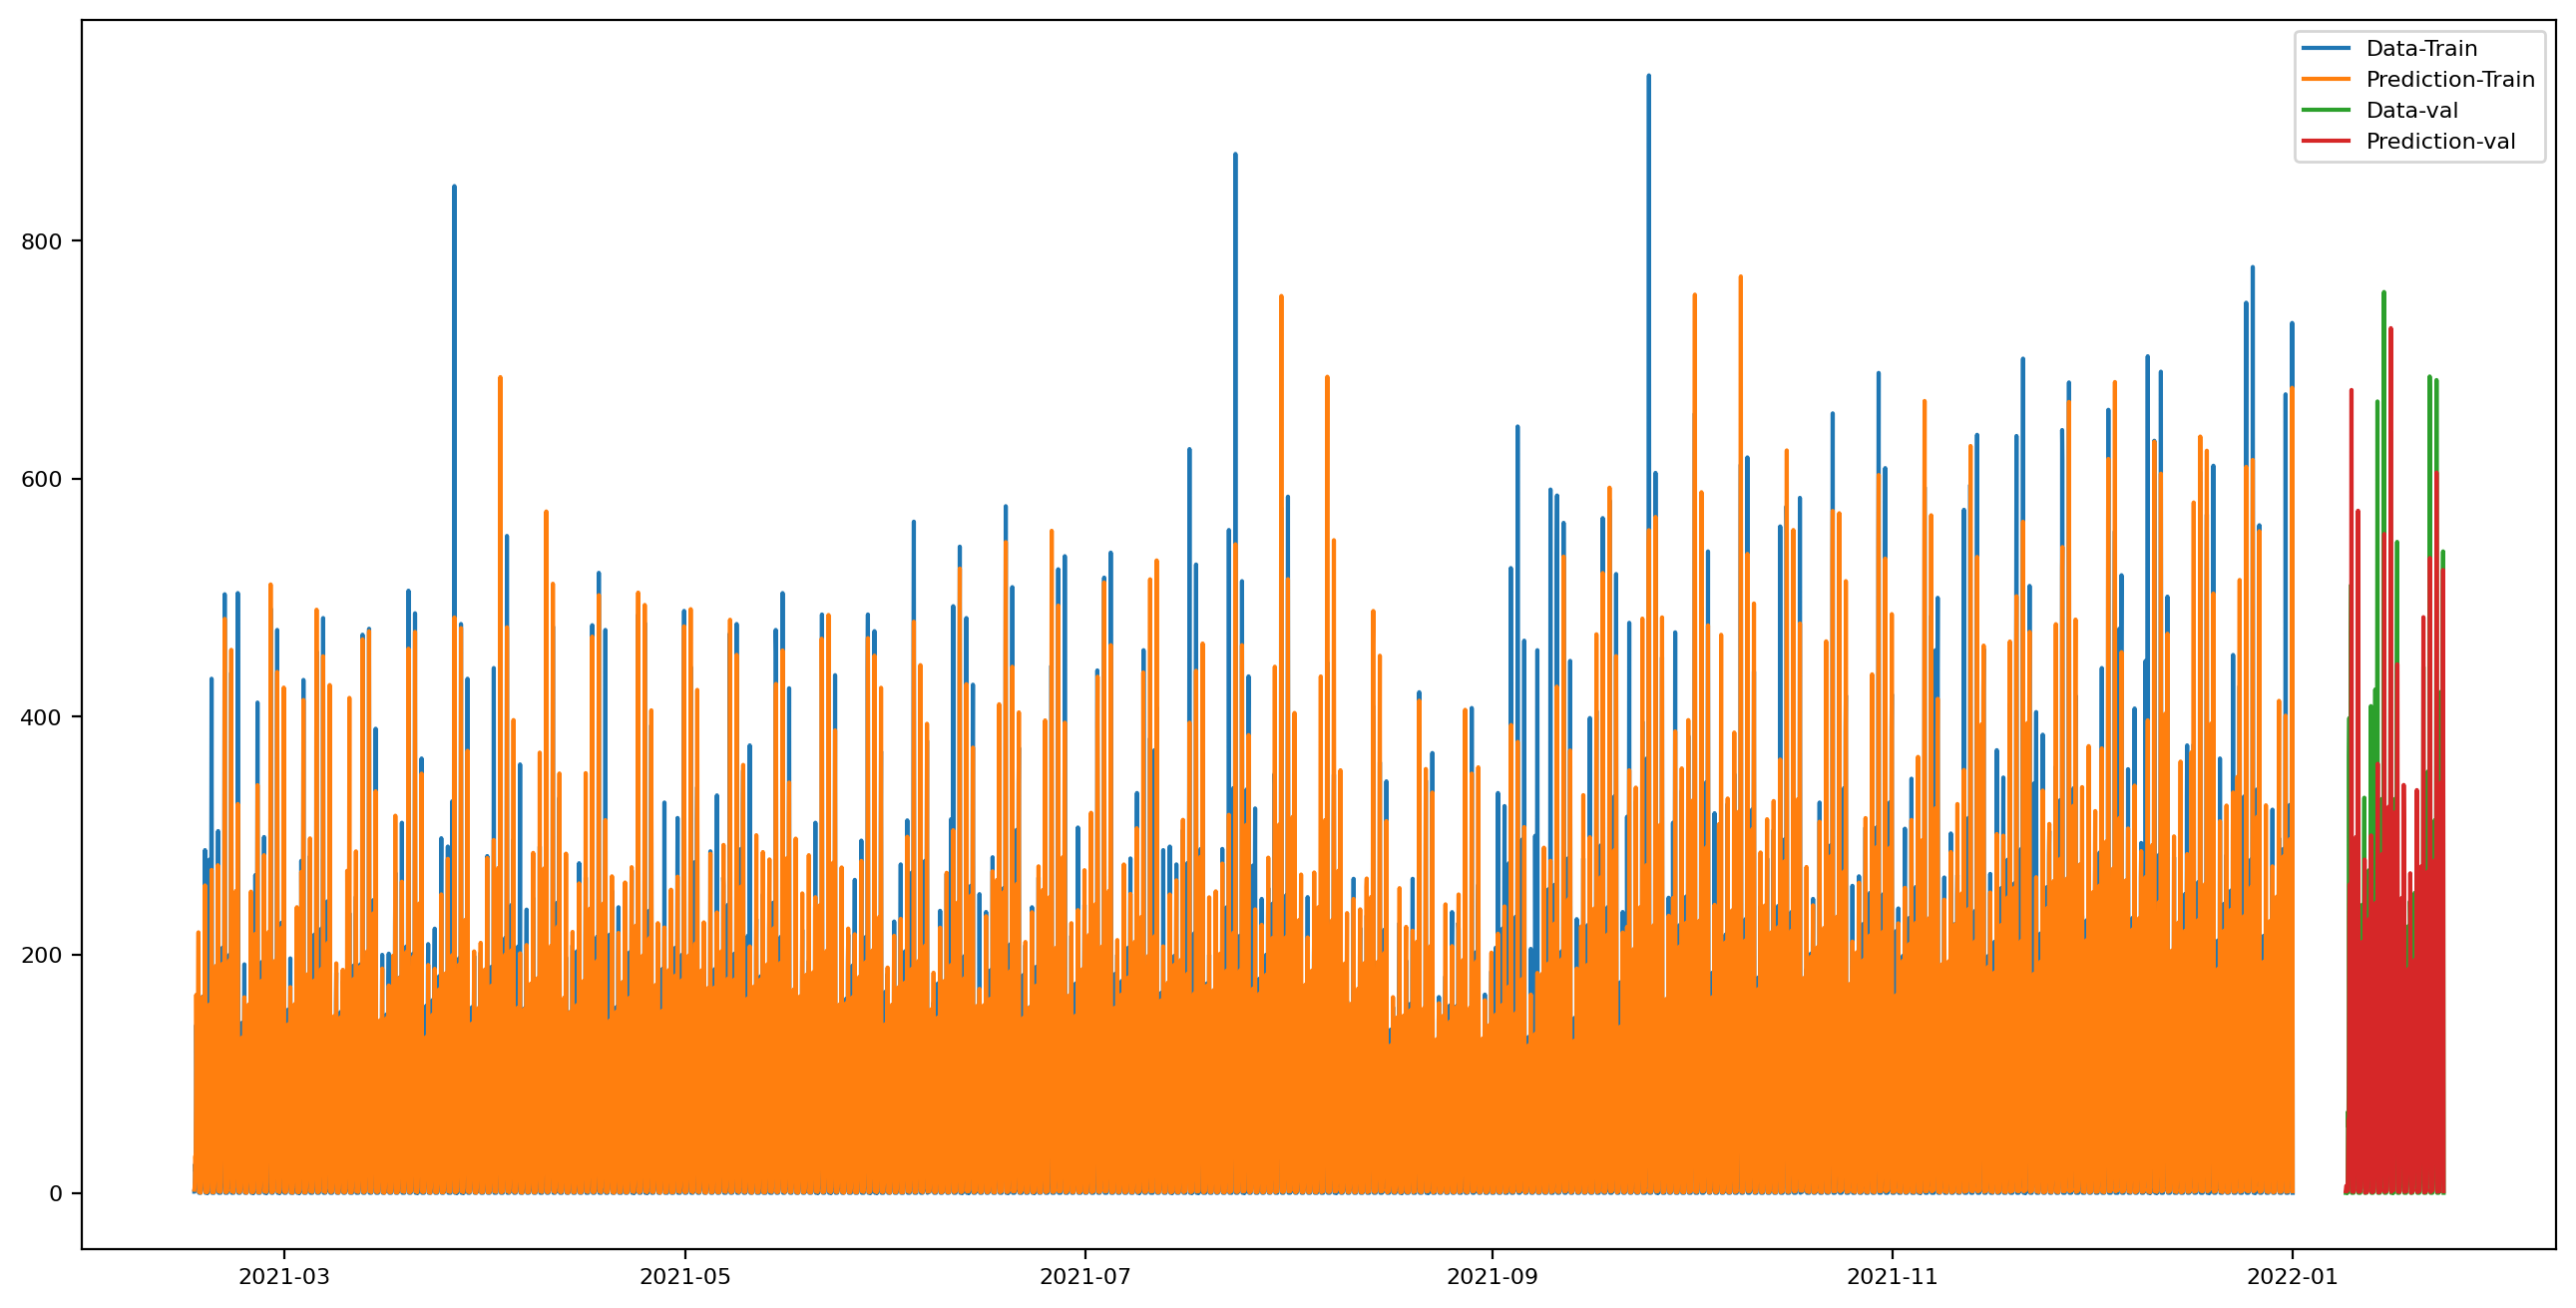

In [47]:
#Lasso - Model build

#build model using training dataframe
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)

#predict orders for validation timeframe
y_pred_val = model.predict(X_val)

# Plot
t = X_train.index
t_val = X_val.index
plt.figure(figsize=(16, 8))
plt.plot(t, y_train, label='Data-Train')
plt.plot(t, y_pred_train, label='Prediction-Train')
plt.plot(t_val, y_val, label='Data-val')
plt.plot(t_val, y_pred_val, label='Prediction-val')
plt.legend()
plt.show()


In [48]:
#Lasso - feature importance

df_features = pd.DataFrame({
    'feature': X_train.columns,
    'coeff': model.coef_
})

df_features['importance'] = df_features['coeff'].abs()/df_features['coeff'].abs().max()
df_features.sort_values(by = ['importance'], ascending = False, inplace = True)
print(df_features)

         feature     coeff  importance
7      cos(4,24) -1.403053    1.000000
0      sin(1,24)  0.831742    0.592809
6      sin(4,24)  0.831553    0.592674
4      sin(3,24)  0.795103    0.566695
24    sin(1,168) -0.558337    0.397944
..           ...       ...         ...
62   sin(20,168)  0.000000    0.000000
61   cos(19,168) -0.000000    0.000000
60   sin(19,168)  0.000000    0.000000
57   cos(17,168) -0.000000    0.000000
152        ohe_6  0.000000    0.000000

[153 rows x 3 columns]


- Lasso: performance metrics

In [49]:
#Lasso: performance metrics - MAE, MSE, RMSE, R-sqrd

#subset to only predict a week out
df_val_pred = pd.concat([pd.DataFrame(y_val, columns = ['orders']),pd.DataFrame(y_pred_val, columns = ['predictions'])], axis = 1)
df_val_pred.reset_index(inplace = True)
df_val_pred = df_val_pred[df_val_pred['index']<168]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(df_val_pred['orders'], df_val_pred['predictions'])
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_val_pred['orders'], df_val_pred['predictions'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R²)
r2 = r2_score(df_val_pred['orders'], df_val_pred['predictions'])
print("R-squared (R²):", r2)


Mean Absolute Error (MAE): 68.24180567291667
Mean Squared Error (MSE): 16068.405921198739
Root Mean Squared Error (RMSE): 126.76121615541064
R-squared (R²): 0.25166937260156863


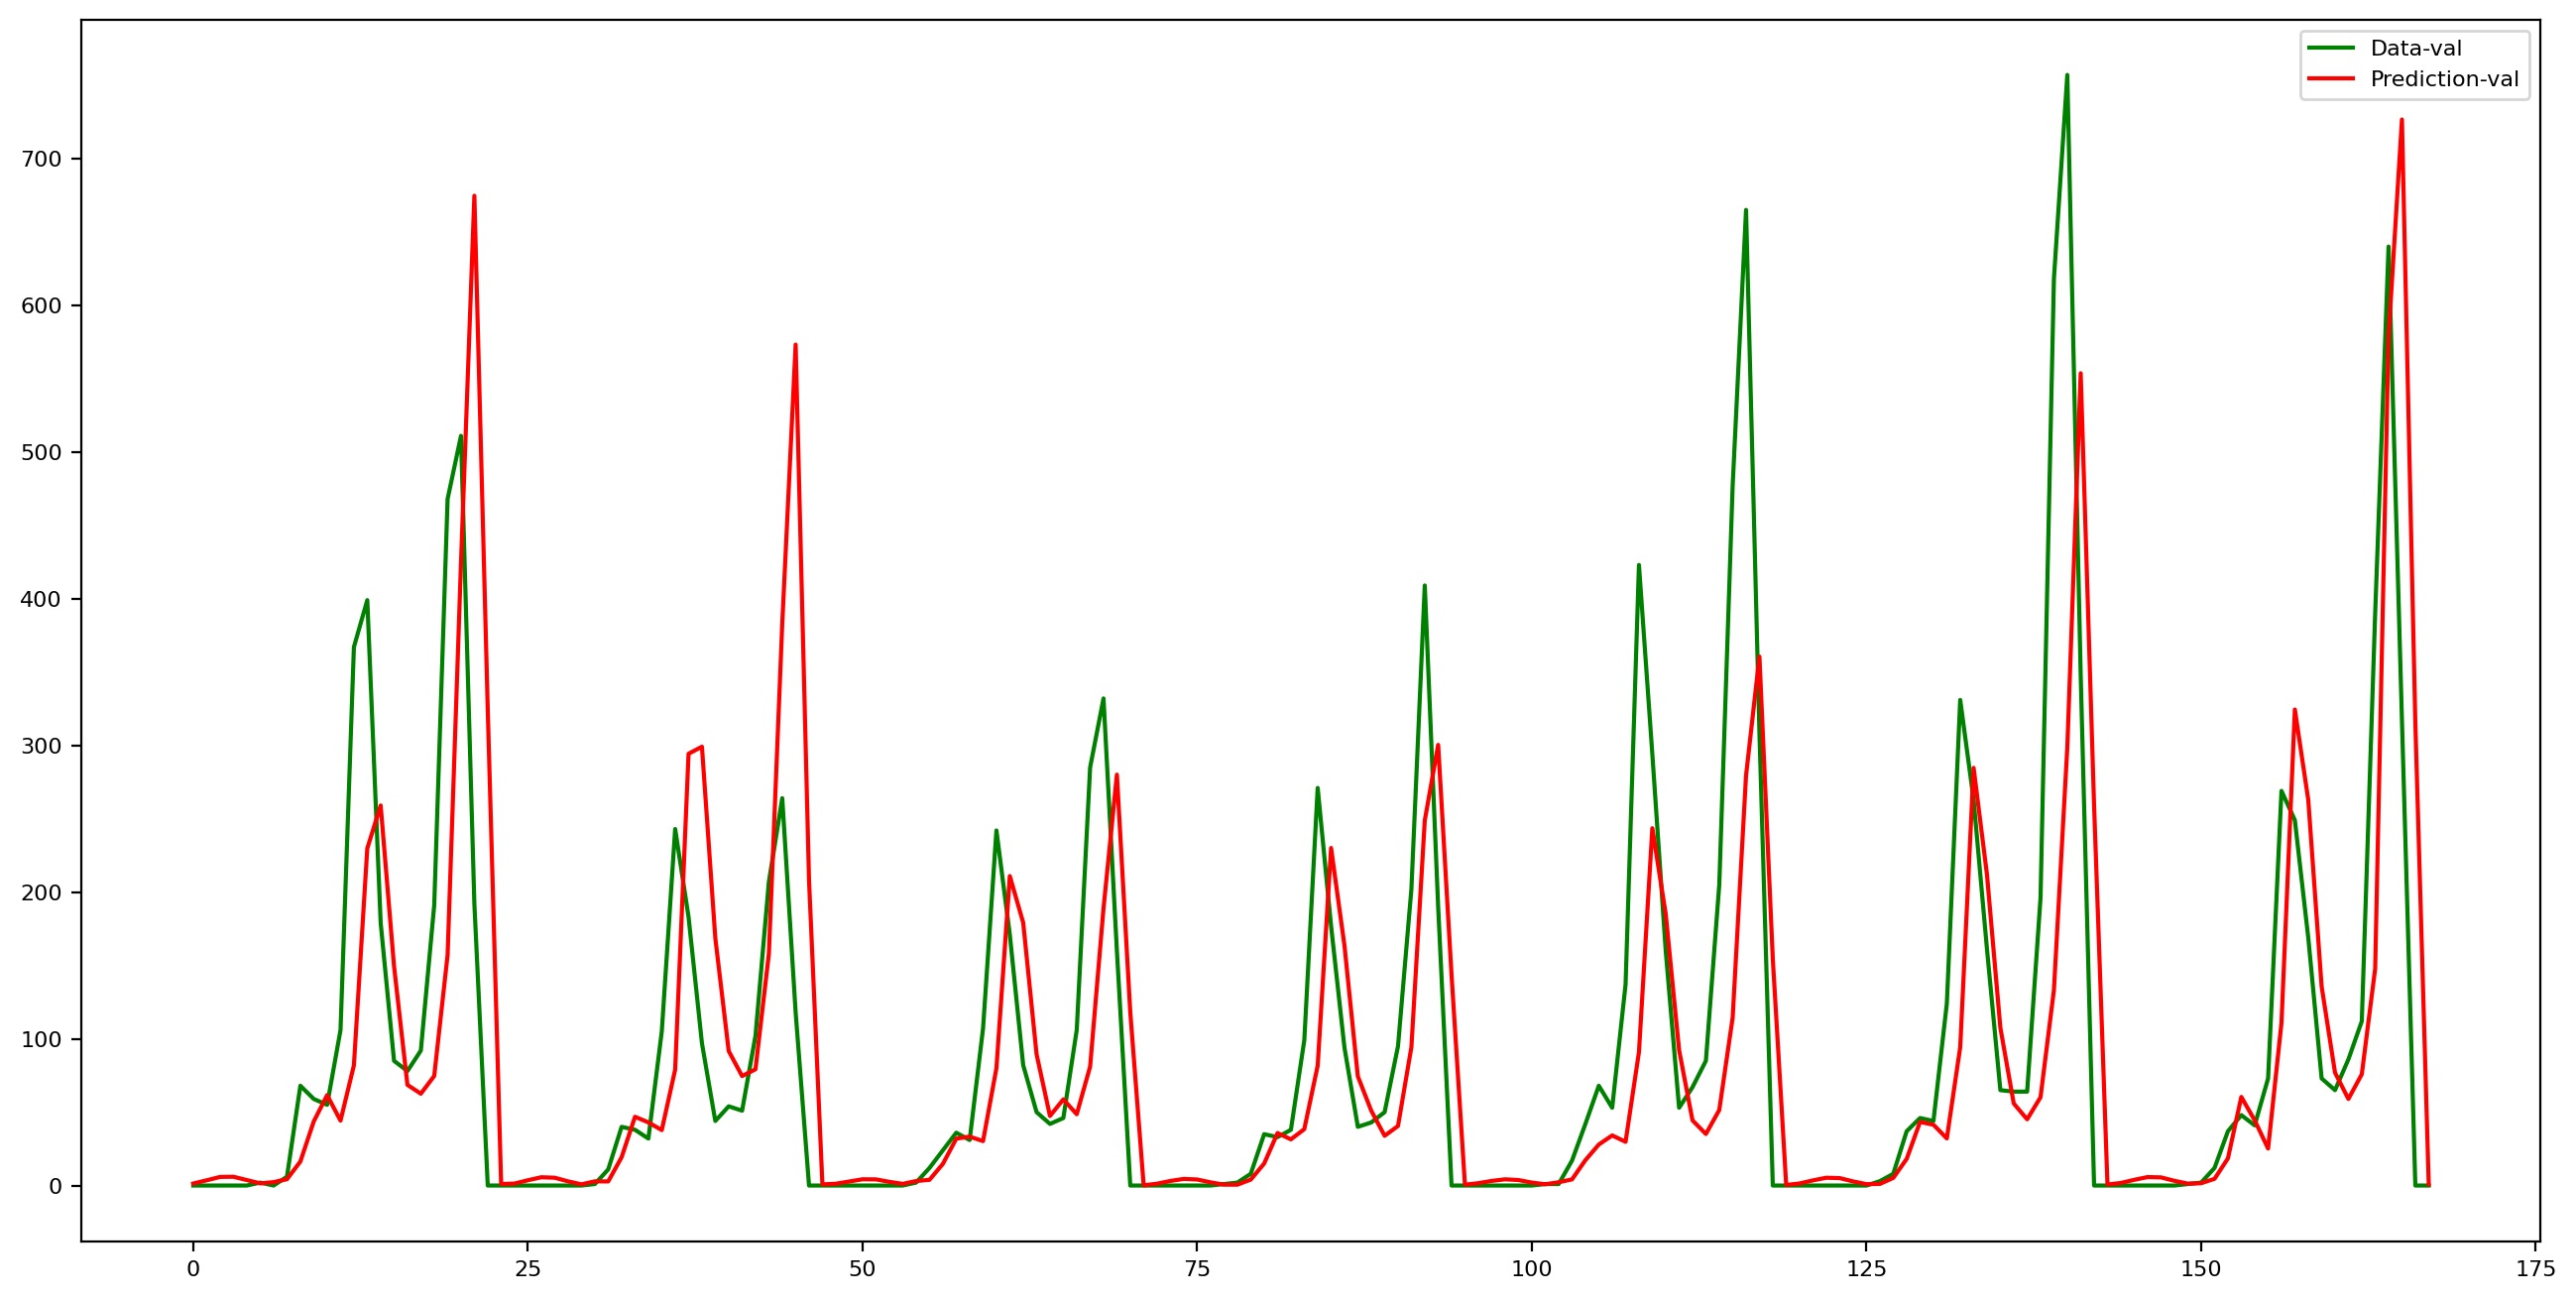

In [50]:
#Lasso: one week prediction plot

# Plot
plt.figure(figsize=(16, 8))
plt.plot(df_val_pred.index, df_val_pred['orders'], label='Data-val', color = 'green')
plt.plot(df_val_pred.index, df_val_pred['predictions'], label='Prediction-val', color = 'red')
plt.legend()
plt.show()


## XGBoost

XGboost overview

- XGBoost: Model build

In [51]:
#xgboost model build

- XGBoost: Performance Metrics

In [52]:
#xgboost performance metrics

## ARIMA/SARIMA

Based on performed tests, we would choose the following orders for ARIMA/SARIMA (p, d, q)(P, D, Q, m):

based on autocorrelation orders: non-sesonal p = 2, seasonal P = 2
based on partial autocorrelation orders: non-seasonal q = 3, seasonal Q = 1
based on ADF test: d = 0
we chose seasonality of 168 (24*7)
Note, that due to the limited computing capacity, we could run SARIMA only with the following orders: (1, 0, 1)(1, 0, 1, 168).

As expected, ARIMA model, which doesn't capture seasonality of any sort performes poorly and predicts just mean orders. On the contrary, SARIMA model performs relatively well and we were able to get predictions with MSE of 1130 and R^2 of 94%.

In [59]:
df_orders.index.min(), df_orders.index.max()

(Timestamp('2021-02-01 00:00:00'), Timestamp('2021-12-31 23:00:00'))

In [58]:
df_val.set_index('time', inplace=True)
df_val.index = pd.to_datetime(df_val.index)  # Ensure index is in datetime format
df_val.index.min(), df_val.index.max()


(Timestamp('2022-01-09 01:00:00'), Timestamp('2022-01-23 23:00:00'))

In [60]:
df_test.set_index('time', inplace=True)
df_test.index = pd.to_datetime(df_test.index)  # Ensure index is in datetime format
df_test.index.min(), df_test.index.max()

(Timestamp('2022-01-23 01:00:00'), Timestamp('2022-01-30 23:00:00'))

- ARIMA

In [62]:
# Define the ARIMA order to use
order = (2, 0, 3)

# Fit an ARIMA model on the training data
model = ARIMA(df_orders['orders'], order=order)
model_fit = model.fit()

# Predict next week's orders using the ARIMA model
start_date = df_val.index.min()
end_date = df_val.index.max()
pred = model_fit.predict(start=len(df_orders), end=len(df_orders)+len(df_val)-1, typ='levels')

# Evaluate model performance on the testing data
mse = mean_squared_error(df_val['orders'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_val['orders'], pred)
r2 = r2_score(df_val['orders'], pred)

# Create a dictionary to store the results
result = {
    'model_name': f"ARIMA_{order[0]}{order[1]}{order[2]}",
    'predictions': pred,
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
    'r2': r2
}

# Print the evaluation metrics
print(f"ARIMA({order[0]}, {order[1]}, {order[2]})")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)
print()

c:\Users\bakwe\my_env2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\bakwe\my_env2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\bakwe\my_env2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 3)
MSE: 20967.222827643724
RMSE: 144.80063130954824
MAE: 93.89624128690267
R-squared: -0.03134447607599733



c:\Users\bakwe\my_env2\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


- SARIMA

In [63]:
# Define the SARIMAX order to use
sarimax_order = ((1, 0, 1), (1, 0, 1, 336))

# Fit a SARIMAX model on the training data
model = SARIMAX(df_orders['orders'], order=sarimax_order[0], seasonal_order=sarimax_order[1])
model_fit = model.fit()

# Predict next week's orders using the SARIMAX model
start_date = df_val.index.min()
end_date = df_val.index.max()
pred = model_fit.predict(start=len(df_orders), end=len(df_orders)+len(df_val)-1, typ='levels')

# Evaluate model performance on the testing data
mse = mean_squared_error(df_val['orders'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_val['orders'], pred)
r2 = r2_score(df_val['orders'], pred)

# Create a dictionary to store the results
result = {
    'model_name': f"SARIMA_{sarimax_order[0]}_{sarimax_order[1]}",
    'predictions': pred,
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
    'r2': r2
}

# Print the evaluation metrics
print(f"SARIMA({sarimax_order[0]}, {sarimax_order[1]})")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)
print()

c:\Users\bakwe\my_env2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\bakwe\my_env2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\bakwe\my_env2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
